# S03_RFM + CHURN + MBA

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from time import time
from shutil import copyfile
import zipfile
from scipy.stats import norm, probplot
import plotly.express as px
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from time import time
import networkx as nx
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score, auc
#KNN
from sklearn.neighbors import KNeighborsClassifier
#SVC
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

#Random Forest
from sklearn.ensemble import RandomForestClassifier
#Logistic
from sklearn.linear_model import LogisticRegression
#Gradient Boosting
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

#MBA
from mlxtend.frequent_patterns import fpgrowth
from mlxtend.frequent_patterns import association_rules

In [ ]:
pip install mlxtend

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
source_path = "/content/drive/MyDrive/marketing analytics/merged dataset.zip"

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
with zipfile.ZipFile(source_path, 'r') as zip:
    zip.extract('dataset.csv')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
dataset = pd.read_csv("dataset.csv")
dataset.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Unnamed: 0                          order_id  customer_id  store_id  \
0           0  8fe4346b53d0c781b275a614175804de           23        49   
1           1  8fe4346b53d0c781b275a614175804de           23        49   
2           2  8fe4346b53d0c781b275a614175804de           23        49   
3           3  8fe4346b53d0c781b275a614175804de           23        49   
4           4  8fe4346b53d0c781b275a614175804de           23        49   

   product_id  product_class  direction  gross_price_revised  price_reduction  \
0    35551922              6          1               125.40              0.0   
1    30344384              6          1                 8.30              0.0   
2    33794292              6          1                 1.99              0.0   
3    33795776              6          1                 5.10              0.0   
4    36235381              6          1                76.05              0.0   

   net_price  ...  address_id genders age_group  postal_code     region  \
0     125.40  ...          21       0     36-45      21050.0  LOMBARDIA   
1       8.30  ...          21       0     36-45      21050.0  LOMBARDIA   
2       1.99  ...          21       0     36-45      21050.0  LOMBARDIA   
3       5.10  ...          21       0     36-45      21050.0  LOMBARDIA   
4      76.05  ...          21       0     36-45      21050.0  LOMBARDIA   

  clean_district  account_id  favorite_store  loyalty_code  \
0             VA      512658              49             0   
1             VA      512658              49             0   
2             VA      512658              49             0   
3             VA      512658              49             0   
4             VA      512658              49             0   

  activation_date_days  
0                  245  
1                  245  
2                  245  
3                  245  
4                  245  

[5 rows x 33 columns]

In [ ]:
dataset.columns

Index(['Unnamed: 0', 'order_id', 'customer_id', 'store_id', 'product_id',
       'product_class', 'direction', 'gross_price_revised', 'price_reduction',
       'net_price', 'pct_discount(%)', 'purchase_date', 'purchase_time',
       'Week', 'Day', 'day_of_week', 'tot_amount_spent',
       'customer_total_purchases', 'tot_number_purchases',
       'last_purchase_date', 'days_from_last_purchase', 'last_day_tot_amount',
       'last_day_num_products', 'address_id', 'genders', 'age_group',
       'postal_code', 'region', 'clean_district', 'account_id',
       'favorite_store', 'loyalty_code', 'activation_date_days'],
      dtype='object')

# RFM

In [ ]:
dataset = dataset[dataset['direction'] != -1]


In order to create the graph 'Customers based on subsequent purchase days', we **exclude** customers with only **one purchase**, since our goal is to study the behaviour of customers who are likely to make further purchases.

However, for distinguishing  between **inactive** and **active** customers, we establish a threshold based on a time interval that captures the period in which **90% of customers repeatedly complete a purchase**. In addition, the group of customers initially excluded (consisting of 34,851 people) will be included again in the analysis and classified as inactive.

In [ ]:
# filter the original dataframe to include only the columns necessary
rpcurve= dataset[['order_id','customer_id','purchase_date','purchase_time']].copy()

# Convert the purchase_date column to datetime
rpcurve['purchase_date'] = pd.to_datetime(rpcurve['purchase_date'])

#drop duplicates and sort the datased on customer_id, purchase_date and order_id
rpcurve.drop_duplicates(subset=['customer_id', 'purchase_date', 'order_id'], keep='first', inplace=True)

In [ ]:
rpcurve[rpcurve['customer_id']== 934317]

order_id  customer_id purchase_date  \
918932  b411674fcfc94e8cdd32fa3fe324f84e       934317    2023-04-30   
918937  77746cb9eb0b08d310ee7b3690a30f39       934317    2023-04-30   

       purchase_time  
918932      17:09:17  
918937      17:39:17

In [ ]:
# Calculate the count of purchases per customer and add it as a new column 'count'
rpcurve['count'] = rpcurve.groupby('customer_id')['customer_id'].transform('count')

# Create a DataFrame containing only customers with one purchase (33783)
customers_one_purchase = rpcurve[rpcurve['count'] == 1][['customer_id']]

# Exclude customers with only one purchase from the original DataFrame 'rpcurve' (order_id è univoco)
rpcurve = rpcurve[~rpcurve['customer_id'].isin(customers_one_purchase['customer_id'])]

In [ ]:
rpcurve[rpcurve['customer_id']== 624162	 ]

order_id  customer_id purchase_date  \
702244  549df2ebae6c80224922c0679efc3e5d       624162    2022-11-10   
702245  9072751bbc0f5f8a205c1d9525b1279d       624162    2022-11-11   
702247  c0d3185f0b83a04f28c22d9a4b38e4bb       624162    2022-12-09   
702248  83fda825207dc719b0612ce568710c60       624162    2022-12-12   
702251  2f156322bdbbd730bf283df751eab50a       624162    2022-12-23   
702254  a95eb38be559b53bbe23d1aacc4c1510       624162    2023-01-02   
702256  9b6251fdcee06a5009b3b61efb5558ce       624162    2023-01-02   
702260  d24b02ea121da3f3dafd600a16eb7dcc       624162    2023-01-02   
702261  288372a81818bd825cbd5b6707f31fc7       624162    2023-01-02   
702266  ea1954fa3826190b8127843b67167d33       624162    2023-01-02   
702268  8c2d9c2db400c164edf027715def8dab       624162    2023-01-02   
702269  9fe6ebd41bf07217f5ce2ccd5e634082       624162    2023-01-02   
702270  6a89ffcb3b842c3769bab0fc8de44cc2       624162    2023-01-02   
702274  b954b33b38ce8a8d4210c7068bdacd0f       624162    2023-01-02   
702276  54a046f7deb72a09b8dd7dd0dcffa1e0       624162    2023-01-02   
702278  7394984702a9fb92548cc832a50a6de6       624162    2023-01-02   
702280  6e2b923cf4584e7b501720b6dfb88b6c       624162    2023-01-02   
702281  cdfc5c16199a18390088c222400a128d       624162    2023-01-02   

       purchase_time  count  
702244      18:08:59     18  
702245      18:51:59     18  
702247      16:27:55     18  
702248      09:10:00     18  
702251      17:34:44     18  
702254      09:34:42     18  
702256      09:36:20     18  
702260      09:37:50     18  
702261      09:39:32     18  
702266      09:41:03     18  
702268      09:42:07     18  
702269      09:44:01     18  
702270      09:45:09     18  
702274      09:46:04     18  
702276      09:47:55     18  
702278      09:49:22     18  
702280      09:50:42     18  
702281      09:52:17     18

In [ ]:
# Calculate the time difference between purchases for each customer
rpcurve['days_diff'] = rpcurve.groupby('customer_id')['purchase_date'].diff().dt.days

# Drop the rows with NaN values (the first purchase for each customer)
#rpcurve.dropna(subset=['days_diff'], inplace=True)

rpcurve['days_average'] = rpcurve.groupby('customer_id')['days_diff'].transform('mean')
rpcurve['days_median'] = rpcurve.groupby('customer_id')['days_diff'].transform('median')
# drop duplictes
rpcurve= rpcurve[['customer_id', 'days_average','days_median']].drop_duplicates(subset=['customer_id'])

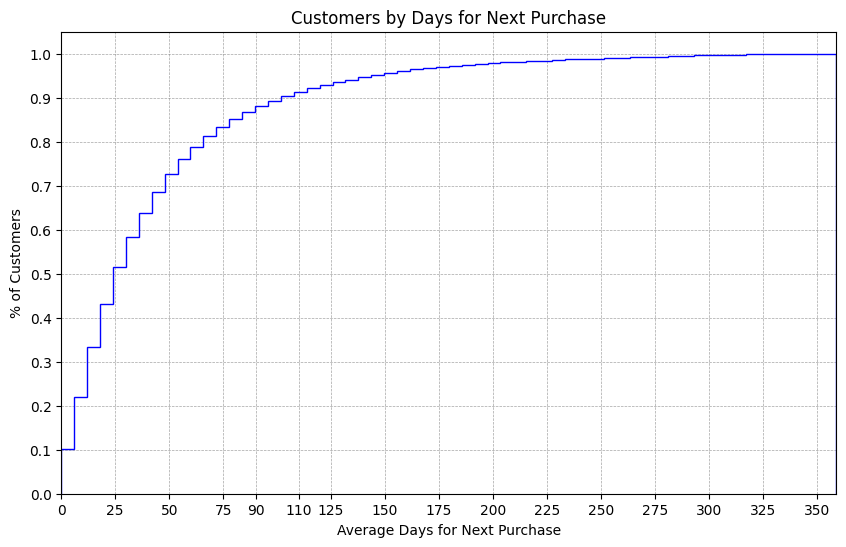

In [ ]:
# Create the graph
plt.figure(figsize=(10, 6))
plt.hist(rpcurve['days_average'], bins=60, density=True, cumulative=True, histtype='step', color='b',label='Empirical')

plt.title('Customers by Days for Next Purchase')
plt.xlabel('Average Days for Next Purchase')
plt.ylabel('% of Customers')

# Set the x-axis range to 0 to 359
plt.xlim(0, 359)
# Valori da mostrare per asse delle x
custom_x_ticks = [0, 25, 50, 75, 90,110, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350]
plt.xticks(custom_x_ticks)
# Valori da mostrare per asse delle y
custom_y_ticks = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
plt.yticks(custom_y_ticks)
plt.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)

plt.show()

In [ ]:
# Calculate the 90th percentile of 'days_median'
percentile_90 = np.percentile(rpcurve['days_median'], 90)

print(f"The 90th percentile of average days for next purchase is: {percentile_90} days")

The 90th percentile of average days for next purchase is: 106.0 days


In [ ]:
# Calculate the 90th percentile of 'days_average'
percentile_90 = np.percentile(rpcurve['days_average'], 90)

print(f"The 90th percentile of average days for next purchase is: {percentile_90} days")

The 90th percentile of average days for next purchase is: 106.0 days


The fact that the mean and median are equal may indicate that most customers have relatively uniform behavior in terms of time between purchases.

In [ ]:
# We consider only customer_id and days_average columns
rpcurve= rpcurve[['customer_id', 'days_average']].drop_duplicates(subset=['customer_id'])

In [ ]:
rpcurve

customer_id  days_average
0                23     23.166667
38               30     42.000000
42               32      7.500000
53               48     18.714286
121              50     32.000000
...             ...           ...
918832       929438      1.000000
918865       929899      3.000000
918889       933057      1.000000
918894       933559      0.000000
918932       934317      0.000000

[70313 rows x 2 columns]

In [ ]:
# Define the threshold for active and inactive customers
threshold = 106
# Create the 'customer_base' column based on the condition
rpcurve['customer_base'] = np.where(rpcurve['days_average'] > threshold, 'Inactive', 'Active')

We reinclude customers with only one purchase and label them as Inactive

In [ ]:
# Concatenate two DataFrames, rpcurve and customers_one_purchase, and reset the index
customers= pd.concat([rpcurve, customers_one_purchase], ignore_index=True)
# Fill missing values in the 'customer_base' column with 'Inactive' in-place
customers['customer_base'].fillna('Inactive', inplace=True)

customers

customer_id  days_average  days_median customer_base
0                23     23.166667         16.0        Active
1                30     42.000000         42.0        Active
2                32      7.500000          7.5        Active
3                48     18.714286          9.0        Active
4                50     32.000000         32.0        Active
...             ...           ...          ...           ...
104091       934484           NaN          NaN      Inactive
104092       934581           NaN          NaN      Inactive
104093       934620           NaN          NaN      Inactive
104094       934660           NaN          NaN      Inactive
104095       934716           NaN          NaN      Inactive

[104096 rows x 4 columns]

In [ ]:
# Get the counts and labels for 'customer_base'
label_cal = customers['customer_base'].value_counts().index
size_cal = customers['customer_base'].value_counts()

# Define colors (lighter shades of blue)
colors = ['#7cb6ff', '#b2e8ff']

# Create a pie chart
fig = px.pie(names=label_cal, values= size_cal, title='Customer Base Distribution',  color_discrete_sequence=colors)

# Adjust the position of the legend and title
fig.update_layout(
    legend=dict(x=0.7, y=0.6),  # Adjust x and y values to position the legend
    title=dict(text='Customer Base Distribution', x=0.5),
    font=dict(size=16),
    title_x=0.4
)

# Show the pie chart
fig.show()

RFM analysis, on the other hand, stands for **Recency**, **Frequency**, **Monetary Value** . It is a technique used to segment customers based on their transactional behavior and a tool of marketing analysis to identify an organization's best customer segment by using certain parameters. These values correspond to crucial customer traits. RFM analysis evaluates three key aspects of customer behavior:

* **Recency** (R): How recently did the customer make a purchase?
* **Frequency** (F): How often does the customer make purchases?
* **Monetary value** (M): How much does the customer spend?

In [ ]:
#As a reference date, we use the last purchase  made in the store ('2023-04-30') to compute the recency feature variable
# We get the three metrcis. they were previously computed in the preprocessing notebook
RFM= dataset.groupby(['customer_id','tot_amount_spent','tot_number_purchases']).agg({'days_from_last_purchase':'first'}).reset_index()
# We filter the dataset, by keeping the columns of our interest
RFM.columns = ['customer_id',  'Monetary_Value','Frequency', 'Recency']
RFM

customer_id  Monetary_Value  Frequency  Recency
0                23          483.13          7       69
1                30         1191.30          2      281
2                32           58.85          3       28
3                48         1585.28         15        0
4                50           28.75          2       70
...             ...             ...        ...      ...
104091       934484           39.10          1        0
104092       934581           33.60          1        0
104093       934620           21.98          1        0
104094       934660            1.90          1        0
104095       934716            6.99          1        0

[104096 rows x 4 columns]

In [ ]:
# Create a new DataFrame 'customerss' by selecting only the 'customer_id' and 'customer_base' columns from the 'customers' DataFrame, and make a copy of it.
customerss =customers[['customer_id','customer_base']].copy()
# Merge the 'customerss' DataFrame with the 'RFM' DataFrame using the 'customer_id' column as the key for the merge operation.
RFM= pd.merge(customerss, RFM, on='customer_id')
# Filter the 'RFM' DataFrame to include only rows where the 'customer_base' column has the value 'Active'.
RFM= RFM[RFM['customer_base'] == 'Active']
RFM

customer_id customer_base  Monetary_Value  Frequency  Recency
0               23        Active          483.13          7       69
1               30        Active         1191.30          2      281
2               32        Active           58.85          3       28
3               48        Active         1585.28         15        0
4               50        Active           28.75          2       70
...            ...           ...             ...        ...      ...
70308       929438        Active           46.46          2        0
70309       929899        Active          296.60          2        0
70310       933057        Active           15.94          2        0
70311       933559        Active           27.96          2        0
70312       934317        Active          107.55          2        0

[63359 rows x 5 columns]

In [ ]:
RFM[['Monetary_Value','Frequency', 'Recency']].describe().transpose()

count        mean         std   min    25%     50%     75%  \
Monetary_Value  63359.0  257.785558  432.198634  0.03  41.91  109.16  283.45   
Frequency       63359.0    4.791016    3.571027  2.00   2.00    4.00    6.00   
Recency         63359.0  114.273126   92.603922  0.00  34.00   92.00  177.00   

                    max  
Monetary_Value  7785.31  
Frequency         49.00  
Recency          364.00

In [ ]:
fig = px.histogram(RFM, x="Recency", marginal="box")
fig.show()

50% of the customers have purchased within 0-92 days range

In [ ]:
fig = px.histogram(RFM, x="Monetary_Value", marginal="box")
fig.show()

On median, each customer have spent around 109.16 euro in the ecommerce

In [ ]:
fig = px.histogram(RFM, x="Frequency", marginal="box")
fig.show()

It has been observed that 50% of Customers have ordered 4 times.


## Calculating RFM Scoring

Since we are **unaware** of the business type and the nature of the items sold, we cannot customise the RFM parameters, weighting them differently, to optimise the customer segmentation methodology.

 We therefore decide to apply the approach presented in class, expressing the RFM values as **descriptive business categories**. Initially, active customers are divided into **three** groups using the percentiles of each of the RFM measures. Next, we combine the frequency and recency percentile groups to calculate new **customer loyalty classifications**.

  Finally, we integrate these loyalty statuses with the monetary value categories to create complete **RFM classes**.

In [ ]:
# Define the quantiles to split the data into three groups
RFM.quantile(q = [0.33, 0.66])


<ipython-input-19-96070999e9fa>:2: FutureWarning:

The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



customer_id  Monetary_Value  Frequency  Recency
0.33    305496.14         58.0400        3.0     49.0
0.66    565798.40        196.6556        5.0    145.0

In [ ]:
def frequency_score(RFM):
    if RFM.Frequency >= 3.0:
        frequency_score = 'High'
    elif RFM.Frequency >= 5.0:
        frequency_score = 'Medium'
    else:
        frequency_score = 'Low'
    return frequency_score

RFM['frequency_score'] = RFM.apply(frequency_score, axis=1)

def recency_score(RFM):
    if RFM.Recency >= 145.0:
        recency_score = 'High'
    elif RFM.Recency >= 49.0:
        recency_score = 'Medium'
    else:
        recency_score = 'Low'
    return recency_score

RFM['recency_score'] = RFM.apply(recency_score, axis=1)

def monetary_score(RFM):
    if RFM.Monetary_Value >= 196.6556:
        monetary_score = 'High'
    elif RFM.Monetary_Value >= 58.0400:
        monetary_score = 'Medium'
    else:
        monetary_score = 'Low'
    return monetary_score

RFM['monetary_score'] = RFM.apply(monetary_score, axis=1)

In [ ]:
RFM

customer_id customer_base  Monetary_Value  Frequency  Recency  \
0               23        Active          483.13          7       69   
1               30        Active         1191.30          2      281   
2               32        Active           58.85          3       28   
3               48        Active         1585.28         15        0   
4               50        Active           28.75          2       70   
...            ...           ...             ...        ...      ...   
70308       929438        Active           46.46          2        0   
70309       929899        Active          296.60          2        0   
70310       933057        Active           15.94          2        0   
70311       933559        Active           27.96          2        0   
70312       934317        Active          107.55          2        0   

      frequency_score recency_score monetary_score  
0                High        Medium           High  
1                 Low          High           High  
2                High           Low         Medium  
3                High           Low           High  
4                 Low        Medium            Low  
...               ...           ...            ...  
70308             Low           Low            Low  
70309             Low           Low           High  
70310             Low           Low            Low  
70311             Low           Low            Low  
70312             Low           Low         Medium  

[63359 rows x 8 columns]

In the context of **customer loyalty statues**, we have define the following classes:


*  **Top**: Customers with both a low recency score and a high frequency score.These are your most valuable and loyal customers.
*  **Leaving Top**: Customers with a high recency score but still have a high frequency score.These customers are starting to show signs of reduced engagement.
* **Engaged**: Customers with moderate recency and frequency scores. They are moderately engaged with your business but not as active as the "Top" customers.
* **One-timer**: Customers with both a low recency score and a low frequency score. These are customers who made a single purchase but haven't returned.
* **Leaving**: Customers with a high recency score and a low frequency score. These customers are becoming less engaged and might be at risk of leaving.



In [ ]:
# Define the conditions and corresponding values for customer loyalty
conditions = [(RFM['recency_score'] == 'Low') & (RFM['frequency_score'] == 'High'),
              (RFM['recency_score'] == 'Medium') & (RFM['frequency_score'] == 'High'),
              (RFM['recency_score'] == 'High') & (RFM['frequency_score'] == 'High'),

              (RFM['recency_score'] == 'Low') & (RFM['frequency_score'] == 'Medium'),
              (RFM['recency_score'] == 'Medium') & (RFM['frequency_score'] == 'Medium'),
              (RFM['recency_score'] == 'High') & (RFM['frequency_score'] == 'Medium'),

              (RFM['recency_score'] == 'Low') & (RFM['frequency_score'] == 'Low'),
              (RFM['recency_score'] == 'Medium') & (RFM['frequency_score'] == 'Low'),
              (RFM['recency_score'] == 'High') & (RFM['frequency_score'] == 'Low'),]

values = ['Top', 'Top', 'Leaving Top', 'Engaged', 'Engaged', 'Leaving', 'One-timer', 'One-timer', 'Leaving']

# Use np.select to assign values based on conditions
RFM['customer_loyalty'] = np.select(conditions, values, default='Other')

In [ ]:
RFM

customer_id customer_base  Monetary_Value  Frequency  Recency  \
0               23        Active          483.13          7       69   
1               30        Active         1191.30          2      281   
2               32        Active           58.85          3       28   
3               48        Active         1585.28         15        0   
4               50        Active           28.75          2       70   
...            ...           ...             ...        ...      ...   
70308       929438        Active           46.46          2        0   
70309       929899        Active          296.60          2        0   
70310       933057        Active           15.94          2        0   
70311       933559        Active           27.96          2        0   
70312       934317        Active          107.55          2        0   

      frequency_score recency_score monetary_score customer_loyalty  
0                High        Medium           High              Top  
1                 Low          High           High          Leaving  
2                High           Low         Medium              Top  
3                High           Low           High              Top  
4                 Low        Medium            Low        One-timer  
...               ...           ...            ...              ...  
70308             Low           Low            Low        One-timer  
70309             Low           Low           High        One-timer  
70310             Low           Low            Low        One-timer  
70311             Low           Low            Low        One-timer  
70312             Low           Low         Medium        One-timer  

[63359 rows x 9 columns]

In [ ]:
RFM["customer_loyalty"].value_counts()


Top            32532
Leaving Top    12193
Leaving         9429
One-timer       9205
Name: customer_loyalty, dtype: int64

In [ ]:
# Define the custom sorting order for RF_classes
custom_order = ['Top', 'Leaving Top', 'Engaged', 'One-timer', 'Leaving']
# Calculate average values for each RFM_Level, and return a size of each segment
customer_loyalty_statues = RFM[['customer_loyalty', 'Recency', 'Frequency', 'Monetary_Value']] \
    .groupby('customer_loyalty') \
    .agg(['mean', 'min', 'median', 'max']) \
    .reindex(custom_order)

customer_loyalty_statues

Recency                      Frequency                    \
                        mean    min median    max      mean  min median   max   
customer_loyalty                                                                
Top                55.109554    0.0   46.0  144.0  6.443256  3.0    5.0  49.0   
Leaving Top       214.527516  145.0  203.0  360.0  4.648077  3.0    4.0  33.0   
Engaged                  NaN    NaN    NaN    NaN       NaN  NaN    NaN   NaN   
One-timer          64.640956    0.0   59.0  144.0  2.000000  2.0    2.0   2.0   
Leaving           237.209990  145.0  233.0  364.0  2.000000  2.0    2.0   2.0   

                 Monetary_Value                          
                           mean   min   median      max  
customer_loyalty                                         
Top                  319.689794  0.06  151.265  7785.31  
Leaving Top          298.201311  0.60  139.250  7050.76  
Engaged                     NaN   NaN      NaN      NaN  
One-timer            118.880784  0.03   42.400  6660.80  
Leaving              127.544867  0.21   47.950  3627.01

Finally, the **RFM-classes** are obtained by combining the **customer loyalty statues** with the **Monetary Value groups**:



*   **Diamond**:These are your most valuable and loyal customers who have both a high monetary score and a high customer loyalty score.They are the top-tier customers who contribute significantly to your business.
*   **Gold**: These customers also have a high monetary score but may not be as loyal as Diamond customers. They are still valuable and engaged but not at the highest level.
*   **Silver**: Silver customers have a moderate monetary score and may fall into different loyalty categories.They are moderately engaged and contribute consistently to your business.
*   **Bronze**: Bronze customers have a low monetary score but can vary in terms of loyalty. They are not as valuable as higher-ranked customers and may be showing signs of reduced engagement.
*   **Copper**: Copper customers have a low monetary score and may be in various loyalty categories, indicating lower spending and potentially reduced engagement.
*  **Tin**: Tin customers are those with both low monetary scores and low loyalty scores. They are not very valuable and are not highly engaged.
*   **Cheap**:  This category likely represents customers who made a single purchase but haven't returned. They have minimal monetary value and may not be actively engaged with your business.



In [ ]:
# Define the conditions and corresponding values for customer loyalty
conditions = [(RFM['monetary_score'] == 'High') & (RFM['customer_loyalty'] == 'Top'),
              (RFM['monetary_score'] == 'Medium') & (RFM['customer_loyalty'] == 'Top'),
              (RFM['monetary_score'] == 'Low') & (RFM['customer_loyalty'] == 'Top'),

              (RFM['monetary_score'] == 'High') & (RFM['customer_loyalty'] == 'Leaving Top'),
              (RFM['monetary_score'] == 'Medium') & (RFM['customer_loyalty'] == 'Leaving Top'),
              (RFM['monetary_score'] == 'Low') & (RFM['customer_loyalty'] == 'Leaving Top'),

              (RFM['monetary_score'] == 'High') & (RFM['customer_loyalty'] == 'Engaged'),
              (RFM['monetary_score'] == 'Medium') & (RFM['customer_loyalty'] == 'Engaged'),
              (RFM['monetary_score'] == 'Low') & (RFM['customer_loyalty'] == 'Engaged'),

              (RFM['monetary_score'] == 'High') & (RFM['customer_loyalty'] == 'Leaving'),
              (RFM['monetary_score'] == 'Medium') & (RFM['customer_loyalty'] == 'Leaving'),
              (RFM['monetary_score'] == 'Low') & (RFM['customer_loyalty'] == 'Leaving'),

              (RFM['monetary_score'] == 'High') & (RFM['customer_loyalty'] == 'One-timer'),
              (RFM['monetary_score'] == 'Medium') & (RFM['customer_loyalty'] == 'One-timer'),
              (RFM['monetary_score'] == 'Low') & (RFM['customer_loyalty'] == 'One-timer')]



values = ['Diamond', 'Gold', 'Silver', 'Gold', 'Silver', 'Bronze', 'Silver', 'Bronze', 'Copper', 'Bronze', 'Copper', 'Tin', 'Copper', 'Tin', 'Cheap']

# Use np.select to assign values based on conditions
RFM['RFM_classes'] = np.select(conditions, values, default='Other')

In [ ]:
RFM

customer_id customer_base  Monetary_Value  Frequency  Recency  \
0               23        Active          483.13          7       69   
1               30        Active         1191.30          2      281   
2               32        Active           58.85          3       28   
3               48        Active         1585.28         15        0   
4               50        Active           28.75          2       70   
...            ...           ...             ...        ...      ...   
70308       929438        Active           46.46          2        0   
70309       929899        Active          296.60          2        0   
70310       933057        Active           15.94          2        0   
70311       933559        Active           27.96          2        0   
70312       934317        Active          107.55          2        0   

      frequency_score recency_score monetary_score customer_loyalty  \
0                High        Medium           High              Top   
1                 Low          High           High          Leaving   
2                High           Low         Medium              Top   
3                High           Low           High              Top   
4                 Low        Medium            Low        One-timer   
...               ...           ...            ...              ...   
70308             Low           Low            Low        One-timer   
70309             Low           Low           High        One-timer   
70310             Low           Low            Low        One-timer   
70311             Low           Low            Low        One-timer   
70312             Low           Low         Medium        One-timer   

      RFM_classes  
0         Diamond  
1          Bronze  
2            Gold  
3         Diamond  
4           Cheap  
...           ...  
70308       Cheap  
70309      Copper  
70310       Cheap  
70311       Cheap  
70312         Tin  

[63359 rows x 10 columns]

In [ ]:
RFM['RFM_classes'].value_counts()

Gold       16537
Diamond    13704
Silver     11375
Tin         7707
Cheap       5390
Bronze      4721
Copper      3925
Name: RFM_classes, dtype: int64

In [ ]:
# Plot RFM levels

fig = px.histogram(RFM, x="RFM_classes", color="RFM_classes", color_discrete_map={'Diamond' : '#7400b8', 'Gold':'#6930c3', 'Silver':'#5e60ce', 'Bronze' :'#5390d9', 'Copper':'#48bfe3', 'Tin':'#56cfe1', 'Cheap':'#64dfdf'},
                   category_orders={"RFM_classes": ['Diamond', 'Gold','Silver',  'Bronze', 'Copper','Tin', 'Cheap', ]} )

fig.update_layout(
    title=dict(text='Distribution of RFM clasess', x=0.5),
    font=dict(size=16),
    title_x=0.4
)

fig.show()

In [ ]:
# Define the custom sorting order for RF_classes
custom_order = ['Diamond', 'Gold', 'Silver', 'Bronze', 'Copper', 'Tin', 'Cheap']

# Group by RF_classes and calculate the desired statistics, while ensuring the custom order
result = RFM[['RFM_classes', 'Recency', 'Frequency', 'Monetary_Value']] \
    .groupby('RFM_classes') \
    .agg(['mean', 'min', 'median', 'max']) \
    .reindex(custom_order)

result

Recency                  Frequency                 \
                   mean  min median  max      mean min median max   
RFM_classes                                                         
Diamond       52.548964    0   44.0  144  8.287288   3    7.0  49   
Gold         102.751587    0   79.0  360  5.668440   3    5.0  33   
Silver       116.375560    0  101.0  359  4.213275   3    4.0  20   
Bronze       223.397162  145  213.0  363  3.023936   2    3.0  12   
Copper       177.520510    0  179.0  362  2.000000   2    2.0   2   
Tin          181.200856    0  184.0  364  2.000000   2    2.0   2   
Cheap         64.783673    0   59.0  144  2.000000   2    2.0   2   

            Monetary_Value                            
                      mean     min   median      max  
RFM_classes                                           
Diamond         643.135541  196.67  424.230  7785.31  
Gold            265.816473   58.04  139.480  7050.76  
Silver           63.849017    0.06   48.050   196.56  
Bronze          189.254340    0.60   44.470  3627.01  
Copper          249.472734   58.05  140.000  6660.80  
Tin              51.219199    0.21   34.500   196.40  
Cheap            24.122362    0.03   21.295    57.99

In [ ]:
ok= pd.merge(dataset, RFM, on='customer_id', how='inner')

In [ ]:
ok.columns

Index(['Unnamed: 0', 'order_id', 'customer_id', 'store_id', 'product_id',
       'product_class', 'direction', 'gross_price_revised', 'price_reduction',
       'net_price', 'pct_discount(%)', 'purchase_date', 'purchase_time',
       'Week', 'Day', 'day_of_week', 'tot_amount_spent',
       'customer_total_purchases', 'tot_number_purchases',
       'last_purchase_date', 'days_from_last_purchase', 'last_day_tot_amount',
       'last_day_num_products', 'address_id', 'genders', 'age_group',
       'postal_code', 'region', 'clean_district', 'account_id',
       'favorite_store', 'loyalty_code', 'activation_date_days',
       'customer_base', 'Monetary_Value', 'Frequency', 'Recency',
       'frequency_score', 'recency_score', 'monetary_score',
       'customer_loyalty', 'RFM_classes'],
      dtype='object')

In [ ]:
ok[['customer_id', 'order_id', 'product_id','gross_price_revised','net_price','price_reduction', 'pct_discount(%)']][ok['customer_id']==30]

customer_id                          order_id  product_id  \
36           30  88b9dc81f8b601c78824ac62311a7eb4    35649740   
37           30  2685d6e34e5f26eea7bd6143fa7ed3e4    35075523   
38           30  2685d6e34e5f26eea7bd6143fa7ed3e4    35765324   
39           30  2685d6e34e5f26eea7bd6143fa7ed3e4    48500403   

    gross_price_revised  net_price  price_reduction  pct_discount(%)  
36                  3.1       3.41             0.31             9.09  
37                 15.1      16.61             1.51             9.09  
38                 49.5      54.45             4.95             9.09  
39               1123.6    1167.98            44.44             3.80

In [ ]:
ok.groupby(['RFM_classes', 'customer_id', 'order_id'])['products_id'].count()

RFM_classes  customer_id  order_id                        
Bronze       30           2685d6e34e5f26eea7bd6143fa7ed3e4    7.326667
                          88b9dc81f8b601c78824ac62311a7eb4    9.090000
             95           09d76e209b74b5d4ac16a1e8238f1189    0.000000
                          bbc5e2ceeff86bf2294d548ad6ffd9d1    0.000000
                          d0faa7b23b112b913705f8d167239fec    0.000000
                                                                ...   
Tin          927975       cf397063a729ff67ec6e7283ccf35bc2    0.000000
             928707       032ee9a8f10f1f025eeb820e71b5cb02    0.000000
                          26e1744b14201797c39fbdfe1cca0229    0.000000
             934317       77746cb9eb0b08d310ee7b3690a30f39    0.000000
                          b411674fcfc94e8cdd32fa3fe324f84e    7.978000
Name: pct_discount(%), Length: 303545, dtype: float64

In [ ]:
 grouped.groupby('RFM_classes').mean()

RFM_classes
Bronze     2.170998
Cheap      1.935065
Copper     3.147643
Diamond    2.934142
Gold       2.515831
Silver     2.012353
Tin        2.219541
Name: product_id, dtype: float64

In [ ]:
result = RFM.groupby('RFM_classes').agg(
    m_Recency=('Recency', 'mean'),
    m_Frequency=('Frequency', 'mean'),
    m_Monetary_Value=('Monetary_Value', 'mean'),
    count=('RFM_classes', 'count')
).reset_index()

In [ ]:
fig = px.treemap(
    result,
    path=['RFM_classes'],
    values='count',
    color='RFM_classes',
)
fig.update_layout(
    width=800,
    height=600,
    margin=dict(t=10, l=10, r=10, b=5),
    font=dict(size=22)
)

fig.show()

## Exporting


In [ ]:
RFM.to_csv('RFM.csv')
!cp RFM.csv "drive/MyDrive/marketing analytics"

# Churn

In predicting churn, we chose to consider only those customers considered active. In our context, we defined active customers as those who made more than one purchase within a 106-day period, as previously defined by the re-purchase curve.

In [ ]:
customerss= customers[['customer_id', 'customer_base']].copy()
df= dataset.copy()
# We merge them
df= pd.merge(df, customerss, on= 'customer_id')

In [ ]:
# Replace 0 with NaN for  string 0s
df['region'].replace('0', np.nan, inplace=True)
df['clean_district'].replace('0', np.nan, inplace=True)

df= df[df['customer_base']== 'Active']

In [ ]:
df['direction'].value_counts()

1    776253
Name: direction, dtype: int64

In [ ]:
df.columns

Index(['Unnamed: 0', 'order_id', 'customer_id', 'store_id', 'product_id',
       'product_class', 'direction', 'gross_price_revised', 'price_reduction',
       'net_price', 'pct_discount(%)', 'purchase_date', 'purchase_time',
       'Week', 'Day', 'day_of_week', 'tot_amount_spent',
       'customer_total_purchases', 'tot_number_purchases',
       'last_purchase_date', 'days_from_last_purchase', 'last_day_tot_amount',
       'last_day_num_products', 'address_id', 'genders', 'age_group',
       'postal_code', 'region', 'clean_district', 'account_id',
       'favorite_store', 'loyalty_code', 'activation_date_days',
       'customer_base'],
      dtype='object')

In [ ]:
df['purchase_date'] = pd.to_datetime(df['purchase_date'])
last_purchase_date=df['purchase_date'].max()
holdout_start_date = last_purchase_date - pd.DateOffset(days=106)
lookback_period_start=holdout_start_date - pd.DateOffset(days=121)

print(f'ultima data:{last_purchase_date}')
print(f'reference date:{holdout_start_date}')
print(f'inizio lookback period:{lookback_period_start}')

ultima data:2023-04-30 00:00:00
reference date:2023-01-14 00:00:00
inizio lookback period:2022-09-15 00:00:00


Customers who made a purchase during the lookback period and continued to make a purchase during the holdout period are considered as non-churned.

In [ ]:
# Create a new column 'churn' initialized with 0
df['churn'] = 1

# Identify customers who made a purchase during lookback
lookback_customers= df[(df['purchase_date'] >= lookback_period_start) & (df['purchase_date'] < holdout_start_date)]['customer_id'].unique()

# Identify customers who made a purchase during holdout
holdout_customers = df[(df['purchase_date'] >= holdout_start_date) & (df['purchase_date'] <= last_purchase_date)]['customer_id'].unique()

# Set churn = 0 for customers who meet the specified conditions
df.loc[df['customer_id'].isin(lookback_customers) & df['customer_id'].isin(holdout_customers), 'churn'] = 0

# we ccompute average discount (%) for every customer
df['average_discount(%)']= df.groupby('customer_id')['pct_discount(%)'].transform('mean')

In [ ]:
# drop duplictes
df= df[['customer_id', 'genders','age_group', 'region', 'favorite_store',
            'activation_date_days','loyalty_code', 'average_discount(%)',
            'tot_amount_spent','customer_total_purchases', 'days_from_last_purchase','churn' ]].drop_duplicates(subset=['customer_id'])
df=df.rename(columns={'tot_amount_spent':'Monetary_Value', 'customer_total_purchases':'Frequency', 'days_from_last_purchase':'Recency'})

#we drop customer_id
df.drop(columns=['customer_id'], inplace=True)

In [ ]:
df

genders age_group     region  favorite_store  activation_date_days  \
0             0     36-45  LOMBARDIA              49                   245   
36            0     36-45  LOMBARDIA              49                   334   
40            1     26-35  LOMBARDIA              49                    57   
51            1     66-75  LOMBARDIA              49                   276   
103           0     36-45  LOMBARDIA              49                   169   
...         ...       ...        ...             ...                   ...   
888043        1     36-45  LOMBARDIA              30                    12   
888075        1     36-45     MOLISE              25                    14   
888099        1     56-65      LAZIO              37                    12   
888104        1     36-45   CALABRIA               3                    11   
888142        1     36-45    SICILIA              28                    11   

        loyalty_code  average_discount(%)  Monetary_Value  Frequency  Recency  \
0                  0             2.013611          483.13         36       69   
36                 2             7.767500         1191.30          4      281   
40                 3             0.000000           58.85         11       28   
51                 2             3.356731         1585.28         52        0   
103                2             6.535000           28.75          4       70   
...              ...                  ...             ...        ...      ...   
888043             0             0.000000           46.46          5        0   
888075             0             0.000000          296.60          7        0   
888099             2             0.000000           15.94          2        0   
888104             0             0.000000           27.96          2        0   
888142             0             6.648333          107.55          6        0   

        churn  
0           0  
36          1  
40          1  
51          0  
103         1  
...       ...  
888043      1  
888075      1  
888099      1  
888104      1  
888142      1  

[63359 rows x 11 columns]

In [ ]:
# Get the counts and labels for 'customer_base'
label_cal = df['churn'].value_counts().index
size_cal = df['churn'].value_counts()

# Define colors (lighter shades of blue)
colors = ['#5b7b99', '#a5b8c9']

# Create a pie chart
fig = px.pie(names=label_cal, values= size_cal, title='Customer Base Distribution',  color_discrete_sequence=colors)

# Adjust the position of the legend and title
fig.update_layout(
    legend=dict(x=0.7, y=0.6),  # Adjust x and y values to position the legend
    title=dict(text='Churn Distribution', x=0.5),
    font=dict(size=16),
    title_x=0.4
)

# Show the pie chart
fig.show()

We obtained that 77,2% of the customers are classified as churners, while the remaining 22,8% of customers are not churners.This distribution indicates that the dataset is **imbalanced**.

In [ ]:
df[df["churn"] == 0].groupby(by=dataset["genders"]).size()

genders
0.0     9313
1.0    11631
dtype: int64

In [ ]:
df[df["churn"] == 1].groupby(by=dataset["genders"]).size()

genders
0.0    17542
1.0    22737
dtype: int64

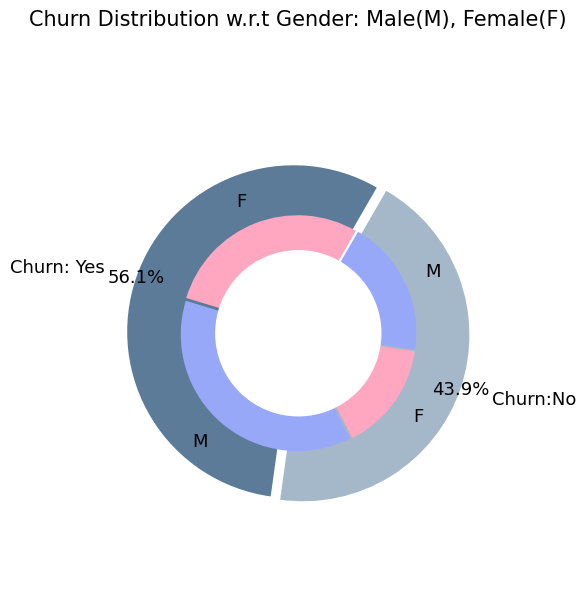

In [ ]:
#{"M": 1, "F": 0})
plt.figure(figsize=(6, 6))
labels =["Churn: Yes","Churn:No"]
values = [34368,26855]
labels_gender = ["F","M","F","M"]
sizes_gender = [17542,22737 , 9313,11631]
colors = ['#5b7b99', '#a5b8c9']
colors_gender = ['#ffa6c1','#96a8f7', '#ffa6c1','#96a8f7']
explode = (0.3,0.3)
explode_gender = (0.1,0.1,0.1,0.1)
textprops = {"fontsize":13}
#Plot
plt.pie(values, labels=labels,autopct='%1.1f%%',pctdistance=1.00, labeldistance=1.2,colors=colors, startangle=60,frame=True, explode=explode,radius=10, textprops =textprops, counterclock = True, )
plt.pie(sizes_gender,labels=labels_gender,colors=colors_gender, labeldistance=1.2,startangle=60, explode=explode_gender,radius=7, textprops =textprops, counterclock = True, )
#Draw circle
centre_circle = plt.Circle((0,0),5,color='black', fc='white',linewidth=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Churn Distribution w.r.t Gender: Male(M), Female(F)', fontsize=15, y=1.1)

# show plot

plt.axis('equal')
plt.tight_layout()
plt.show()

In [ ]:
df[df["genders"]==0][["loyalty_code", "churn"]].value_counts()

loyalty_code  churn
0             1        13636
              0         5299
2             1         5201
              0         2339
1             1         1553
3             1          800
1             0          558
3             0          358
dtype: int64

In [ ]:
df[df["genders"]==1][["loyalty_code", "churn"]].value_counts()

loyalty_code  churn
0             1        13198
              0         7832
2             1         5094
              0         3789
1             1         1394
              0          920
3             1          800
              0          588
dtype: int64

In [ ]:
colors = {'Standard': '#6CE5E8', 'Business Standard': '#41B8D5', 'Premium': '#2D8BBA', 'Business Premium': '#2F5F98'}

plan_hierarchy = ['Standard', 'Business Standard', 'Premium', 'Business Premium']

fig = go.Figure()

churn_status = ['Churn:No', 'Churn:Yes', 'Churn:No', 'Churn:Yes']
gender = ["Female", "Female", "Male", "Male"]

# Data for each plan
data = {
    'Standard': [5299, 13636, 7832, 13198],
    'Business Standard': [558, 1553, 920, 1394],
    'Premium': [2339, 5201, 3789, 5094],
    'Business Premium': [358, 800, 588, 800]
}

for plan in plan_hierarchy:
    fig.add_trace(go.Bar(
        x=[churn_status, gender],
        y=data[plan],
        name=plan,
        marker_color=colors[plan]
    ))

fig.update_layout(
    title_text="<b>Churn Distribution w.r.t. Internet Service and Gender</b>",
    barmode='group'  # To group bars
)

fig.show()

In [ ]:
#plan_hierarchy = ['standard', 'business standard', 'premium', 'business premium']
fig = go.Figure()

fig.add_trace(go.Bar(
  x = [['Churn:No','Churn:Yes','Churn:No','Churn:Yes'],
       ["Female", "Female", "Male", "Male"]],
  y = [5299, 13636,7832,13198],
  name = 'Standard',
))

fig.add_trace(go.Bar(
  x = [['Churn:No','Churn:Yes','Churn:No','Churn:Yes'],
       ["Female", "Female", "Male", "Male"]],
  y = [ 558, 1553,920,1394],
  name = 'Business standard',
))

fig.add_trace(go.Bar(
  x = [['Churn:No','Churn:Yes','Churn:No','Churn:Yes'],
       ["Female", "Female", "Male", "Male"]],
  y = [ 2339,5201,3789,5094],
  name = 'Premium',
))

fig.add_trace(go.Bar(
  x = [['Churn:No','Churn:Yes','Churn:No','Churn:Yes'],
       ["Female", "Female", "Male", "Male"]],
  y = [358, 800,588,800],
  name = 'Business Premium',
))

fig.update_layout(title_text="<b>Churn Distribution w.r.t. Internet Service and Gender</b>")

fig.show()

In [ ]:
df[df["genders"]==0][["age_group", "churn"]].value_counts().unstack(fill_value=0).sort_values(by="age_group")


churn         0      1
age_group             
18-25        27     69
26-35       794   2280
36-45      4526  14051
46-55      1578   3450
56-65      1110    993
66-75       461    306
76-85        58     40
> 86          0      1

In [ ]:
df[df["genders"]==1][["age_group", "churn"]].value_counts().unstack(fill_value=0).sort_values(by="age_group")

churn         0      1
age_group             
18-25        15     51
26-35       584   1896
36-45      3842  11799
46-55      2668   3581
56-65      3700   2064
66-75      2027    981
76-85       287    111
> 86          6      3

In [ ]:

fig = go.Figure()

fig.add_trace(go.Bar(
  x = [['Churn:No','Churn:Yes','Churn:No','Churn:Yes'],
       ["Female", "Female", "Male", "Male"]],
  y = [27, 69,15,51],
  name = 'age_group(18-25)',
))

fig.add_trace(go.Bar(
  x = [['Churn:No','Churn:Yes','Churn:No','Churn:Yes'],
       ["Female", "Female", "Male", "Male"]],
  y = [ 794,2280,584, 1896 ],
  name = 'age_group(26-35)',
))

fig.add_trace(go.Bar(
  x = [['Churn:No','Churn:Yes','Churn:No','Churn:Yes'],
       ["Female", "Female", "Male", "Male"]],
  y = [4526,14051,3842, 11799],
  name = 'age_group(36-45)',
))
fig.add_trace(go.Bar(
  x = [['Churn:No','Churn:Yes','Churn:No','Churn:Yes'],
       ["Female", "Female", "Male", "Male"]],
  y = [1578, 3450,2668,3581],
  name = 'age_group(46-55)',
))
fig.add_trace(go.Bar(
  x = [['Churn:No','Churn:Yes','Churn:No','Churn:Yes'],
       ["Female", "Female", "Male", "Male"]],
  y = [1100,993, 3700,2064],
  name = 'age_group(56-65)',
))
fig.add_trace(go.Bar(
  x = [['Churn:No','Churn:Yes','Churn:No','Churn:Yes'],
       ["Female", "Female", "Male", "Male"]],
  y = [461,306, 2027,981],
  name = 'age_group(66-75)',
))
fig.add_trace(go.Bar(
  x = [['Churn:No','Churn:Yes','Churn:No','Churn:Yes'],
       ["Female", "Female", "Male", "Male"]],
  y = [ 58,40, 287,111],
  name = 'age_group(76-85)',
))
fig.add_trace(go.Bar(
  x = [['Churn:No','Churn:Yes','Churn:No','Churn:Yes'],
       ["Female", "Female", "Male", "Male"]],
  y = [0,1, 6,	3],
  name = 'age_group(> 86)',
))
fig.update_layout(title_text="<b>Churn Distribution w.r.t. Age Group and Gender</b>")

fig.show()

In [ ]:
dat= df[["favorite_store", "churn"]].value_counts().unstack(fill_value=0).sort_values(by="favorite_store").reset_index()
dat['churn_percentage']= round((dat[1]/ (dat[0]+dat[1]))*100,2)
dat.sort_values(by='churn_percentage', ascending=False)

churn  favorite_store     0     1  churn_percentage
37                 38   508  1307             72.01
12                 13   282   700             71.28
27                 28   297   732             71.14
46                 47   365   843             69.78
19                 20   453   994             68.69
18                 19   293   630             68.26
45                 46   349   739             67.92
3                   4   276   584             67.91
36                 37   492  1037             67.82
48                 49   484  1010             67.60
6                   7   467   966             67.41
4                   5   521  1075             67.36
8                   9   411   844             67.25
25                 26   448   916             67.16
28                 29   437   889             67.04
20                 21   414   829             66.69
7                   8   275   547             66.55
41                 42   244   484             66.48
32                 33   643  1263             66.26
38                 39   538  1051             66.14
22                 23   211   410             66.02
23                 24   337   647             65.75
24                 25   421   806             65.69
0                   1  1750  3328             65.54
44                 45   426   808             65.48
11                 12   358   675             65.34
2                   3   605  1139             65.31
39                 40   499   938             65.27
15                 16   264   496             65.26
26                 27   409   766             65.19
47                 48   407   762             65.18
42                 43   426   793             65.05
34                 35   499   922             64.88
10                 11   289   525             64.50
5                   6   509   924             64.48
21                 22   292   528             64.39
29                 30   329   594             64.36
40                 41   513   899             63.67
14                 15   504   880             63.58
16                 17   458   796             63.48
13                 14   320   556             63.47
31                 32   436   755             63.39
9                  10   446   771             63.35
1                   2   562   970             63.32
30                 31   347   595             63.16
33                 34   767  1256             62.09
43                 44   448   708             61.25
17                 18   324   490             60.20
35                 36   330   499             60.19

In [ ]:
fig = go.Figure()

top_churn_rates = [72.01, 71.28, 71.14, 69.78, 68.69]
bottom_churn_rates = [60.19, 60.20, 61.25, 62.09, 63.16]
store_names_top = ['store_38', 'store_13', 'store_47', 'store_28', 'store_19']
store_names_bottom = ['store_36', 'store_18', 'store_44', 'store_41', 'store_02']

fig.add_trace(go.Bar(x=store_names_top, y=top_churn_rates, name='Top 5 Churn Rates'))
fig.add_trace(go.Bar(x=store_names_bottom, y=bottom_churn_rates, name='Bottom 5 Churn Rates'))

fig.update_layout(title_text="<b>Churn Rates Comparison for Top and Bottom  Favorite Stores</b>")
fig.update_xaxes(title_text='Stores')
fig.update_yaxes(title_text='Churn Rate')

fig.show()

In [ ]:
dat= df[["region", "churn"]].value_counts().unstack(fill_value=0).sort_values(by="region")
dat

churn                     0      1
region                            
ABRUZZO                 445    822
BASILICATA               34     99
CALABRIA                 29     53
CAMPANIA               1696   3543
EMILIA ROMAGNA         1479   2600
ESTERO                   11     13
FRIULI VENEZIA GIULIA   300    642
LAZIO                  2910   5812
LIGURIA                 506   1078
LOMBARDIA              6646  11728
MARCHE                   36     99
MOLISE                   11     55
PIEMONTE               1643   3167
PUGLIA                 1178   2330
SARDEGNA                 10     19
SICILIA                1351   2803
TOSCANA                 724   1625
TRENTINO ALTO ADIGE      17     49
UMBRIA                  419    808
VALLE D'AOSTA             9     25
VENETO                 2090   3623

In [ ]:
# Applica one-hot encoding alle colonne 'age_group', 'region' e 'clean_district'
#df = pd.get_dummies(df, columns=['age_group', 'region', 'clean_district'])
df = pd.get_dummies(df, columns=['age_group','loyalty_code','region'])

In [ ]:
print(f"shape:{df.shape}")
print(f"nomi colonne: {df.columns}")

shape:(63359, 41)
nomi colonne: Index(['genders', 'favorite_store', 'activation_date_days',
       'average_discount(%)', 'Monetary_Value', 'Frequency', 'Recency',
       'churn', 'age_group_18-25', 'age_group_26-35', 'age_group_36-45',
       'age_group_46-55', 'age_group_56-65', 'age_group_66-75',
       'age_group_76-85', 'age_group_> 86', 'loyalty_code_0', 'loyalty_code_1',
       'loyalty_code_2', 'loyalty_code_3', 'region_ABRUZZO',
       'region_BASILICATA', 'region_CALABRIA', 'region_CAMPANIA',
       'region_EMILIA ROMAGNA', 'region_ESTERO',
       'region_FRIULI VENEZIA GIULIA', 'region_LAZIO', 'region_LIGURIA',
       'region_LOMBARDIA', 'region_MARCHE', 'region_MOLISE', 'region_PIEMONTE',
       'region_PUGLIA', 'region_SARDEGNA', 'region_SICILIA', 'region_TOSCANA',
       'region_TRENTINO ALTO ADIGE', 'region_UMBRIA', 'region_VALLE D'AOSTA',
       'region_VENETO'],
      dtype='object')


In [ ]:
correlation = df.corr()['churn'].sort_values(ascending=False)
print(f'Correlation Between Target:\n{correlation}')

Correlation Between Target:
churn                           1.000000
Recency                         0.517297
age_group_36-45                 0.223081
age_group_26-35                 0.061487
loyalty_code_0                  0.037636
average_discount(%)             0.025272
region_TOSCANA                  0.014065
region_MOLISE                   0.011949
region_CAMPANIA                 0.011706
region_SICILIA                  0.009489
age_group_18-25                 0.008853
region_BASILICATA               0.008370
region_LIGURIA                  0.007688
region_MARCHE                   0.007359
region_LAZIO                    0.007230
region_FRIULI VENEZIA GIULIA    0.006150
region_TRENTINO ALTO ADIGE      0.005761
loyalty_code_1                  0.004743
region_VALLE D'AOSTA            0.003786
favorite_store                  0.003436
region_PUGLIA                   0.003276
region_PIEMONTE                 0.000389
region_UMBRIA                   0.000220
region_SARDEGNA              

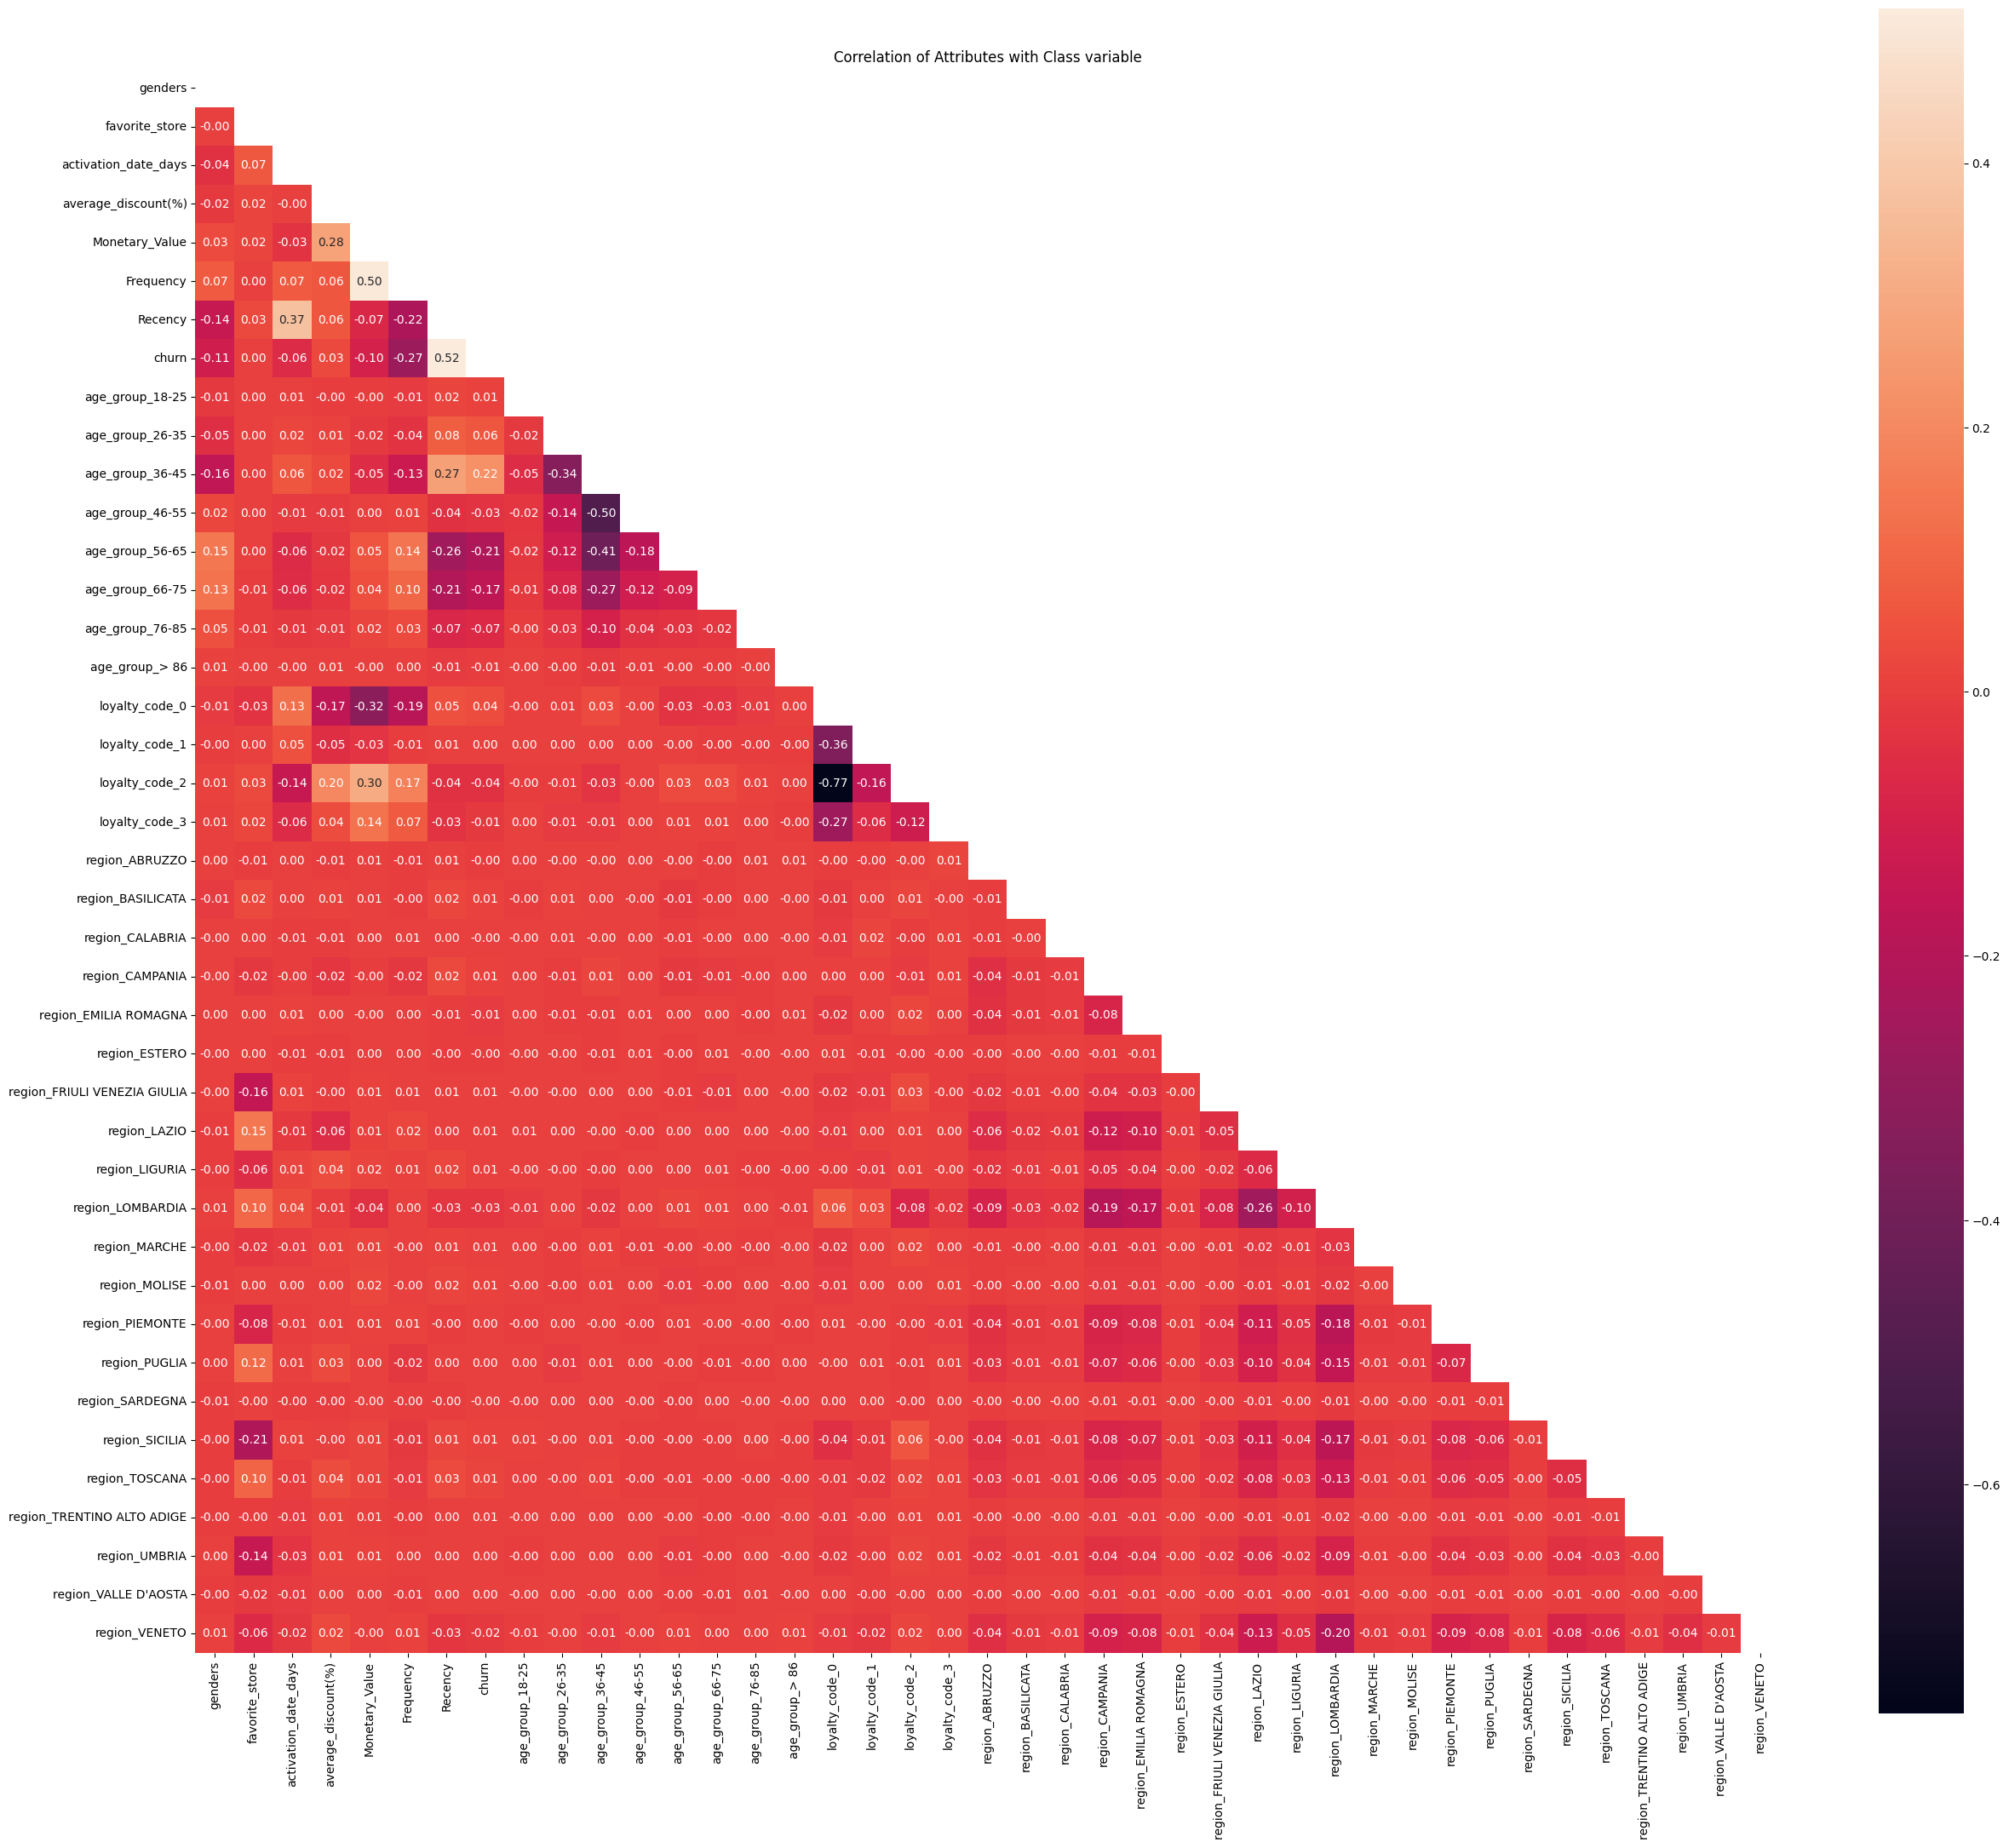

In [ ]:
correlation = df.corr()

# Create a mask to hide the upper triangle of the correlation matrix
mask = np.triu(np.ones_like(correlation, dtype=bool))

plt.figure(figsize=(30, 26))
plt.title('Correlation of Attributes with Class variable')

a = sns.heatmap(correlation, mask=mask, square=True, annot=True, fmt='.2f', linecolor='white')

# Rotate the x-axis labels for better readability
a.set_xticklabels(a.get_xticklabels(), rotation=90)

plt.show()

### Declare feature vector and target variable

In [ ]:
X = df.drop(columns = ['churn'])
y = df['churn'].values

### Split data into separate training and test set

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.20, random_state = 40, stratify=y)
# The stratify parameter is used to maintain the class distribution in the training and testing sets same as the original

In [ ]:
# Check the shape of X_train and X_test
X_train.shape, X_test.shape

((50687, 40), (12672, 40))

In [ ]:
X_test.isnull().sum()

genders                         0
favorite_store                  0
activation_date_days            0
average_discount(%)             0
Monetary_Value                  0
Frequency                       0
Recency                         0
age_group_18-25                 0
age_group_26-35                 0
age_group_36-45                 0
age_group_46-55                 0
age_group_56-65                 0
age_group_66-75                 0
age_group_76-85                 0
age_group_> 86                  0
loyalty_code_0                  0
loyalty_code_1                  0
loyalty_code_2                  0
loyalty_code_3                  0
region_ABRUZZO                  0
region_BASILICATA               0
region_CALABRIA                 0
region_CAMPANIA                 0
region_EMILIA ROMAGNA           0
region_ESTERO                   0
region_FRIULI VENEZIA GIULIA    0
region_LAZIO                    0
region_LIGURIA                  0
region_LOMBARDIA                0
region_MARCHE 

### Feature Engineering

In [ ]:
num_cols = ["average_discount(%)", 'Monetary_Value', 'Frequency','Recency','activation_date_days','favorite_store' ]

In [ ]:
# Standardizing numeric attributes
df_std = pd.DataFrame(StandardScaler().fit_transform(df[num_cols].astype('float64')),
                       columns=num_cols)


In [ ]:
# The numerical columns in both the training and testing sets  have a mean of 0 and a standard deviation of 1
scaler= StandardScaler()

X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

In [ ]:
df_std

average_discount(%)  Monetary_Value  Frequency   Recency  \
0                -0.009858        0.521395   1.871920 -0.488894   
1                 1.761877        2.159937  -0.646245  1.800444   
2                -0.629888       -0.460291  -0.095397 -0.931643   
3                 0.403715        3.071516   3.131003 -1.234009   
4                 1.382366       -0.529935  -0.646245 -0.478095   
...                    ...             ...        ...       ...   
63354            -0.629888       -0.488959  -0.567553 -1.234009   
63355            -0.629888        0.089808  -0.410167 -1.234009   
63356            -0.629888       -0.559575  -0.803631 -1.234009   
63357            -0.629888       -0.531763  -0.803631 -1.234009   
63358             1.417263       -0.347610  -0.488860 -1.234009   

       activation_date_days  favorite_store  
0                 -0.307500        1.650290  
1                  0.423997        1.650290  
2                 -1.852684        1.650290  
3                 -0.052709        1.650290  
4                 -0.932149        1.650290  
...                     ...             ...  
63354             -2.222542        0.398878  
63355             -2.206104        0.069559  
63356             -2.222542        0.859924  
63357             -2.230761       -1.379443  
63358             -2.230761        0.267151  

[63359 rows x 6 columns]

## Machine Learning Model employments and Predictions

In [ ]:
X_train.head()

genders  favorite_store  activation_date_days  average_discount(%)  \
619988        0        0.599867             -0.321496            -0.632858   
166916        0        0.138762              1.527090             1.208993   
89368         1        0.138762             -0.329712            -0.632858   
748715        0       -0.651703             -0.888396            -0.632858   
547325        0        0.665739              0.007141             0.506893   

        Monetary_Value  Frequency   Recency  age_group_18-25  age_group_26-35  \
619988       -0.509517  -0.644091  0.946671                0                0   
166916        1.183922   1.075067 -0.293256                0                0   
89368        -0.162006   0.059201 -1.198943                0                0   
748715       -0.501091  -0.722235  0.332099                0                0   
547325       -0.358569  -0.018943  1.442643                0                0   

        age_group_36-45  ...  region_MOLISE  region_PIEMONTE  region_PUGLIA  \
619988                1  ...              0                0              0   
166916                1  ...              0                0              1   
89368                 1  ...              0                0              1   
748715                1  ...              0                0              0   
547325                0  ...              0                0              0   

        region_SARDEGNA  region_SICILIA  region_TOSCANA  \
619988                0               0               0   
166916                0               0               0   
89368                 0               0               0   
748715                0               0               0   
547325                0               0               0   

        region_TRENTINO ALTO ADIGE  region_UMBRIA  region_VALLE D'AOSTA  \
619988                           0              0                     0   
166916                           0              0                     0   
89368                            0              0                     0   
748715                           0              0                     0   
547325                           0              0                     0   

        region_VENETO  
619988              0  
166916              0  
89368               0  
748715              0  
547325              0  

[5 rows x 40 columns]

In [ ]:
X_test.head()

genders  favorite_store  activation_date_days  average_discount(%)  \
445642        1        1.653821              0.146812            -0.632858   
689779        1        0.072890             -0.641918             0.107007   
493737        0       -1.046936              0.228972            -0.632858   
154074        0       -0.058854              1.592817            -0.632858   
784660        1        0.072890             -1.069147            -0.632858   

        Monetary_Value  Frequency   Recency  age_group_18-25  age_group_26-35  \
445642       -0.512841  -0.565947  0.332099                0                1   
689779        1.240294   1.153210 -0.692190                0                0   
493737       -0.568936  -0.644091  1.388733                0                0   
154074       -0.505731  -0.800378  1.076055                0                0   
784660        1.951081   0.606206 -0.638280                0                0   

        age_group_36-45  ...  region_MOLISE  region_PIEMONTE  region_PUGLIA  \
445642                0  ...              0                0              0   
689779                0  ...              0                0              0   
493737                1  ...              0                0              0   
154074                0  ...              0                0              0   
784660                0  ...              0                0              0   

        region_SARDEGNA  region_SICILIA  region_TOSCANA  \
445642                0               0               0   
689779                0               0               0   
493737                0               0               0   
154074                0               0               0   
784660                0               0               0   

        region_TRENTINO ALTO ADIGE  region_UMBRIA  region_VALLE D'AOSTA  \
445642                           0              0                     0   
689779                           0              0                     0   
493737                           0              0                     0   
154074                           0              0                     0   
784660                           0              0                     0   

        region_VENETO  
445642              0  
689779              0  
493737              0  
154074              0  
784660              0  

[5 rows x 40 columns]

### knn

It is a non-parametric algorithm used for classification and regression tasks.Non-parametric means there is no assumption required for data distribution.The kNN algorithm intuition is very simple to understand. It simply calculates the distance between a sample data point and all the other training data points. The distance can be Euclidean distance or Manhattan distance. Then, it selects the k nearest data points where k can be any integer. Finally, it assigns the sample data point to the class to which the majority of the k data points belong.

In [ ]:
# Setup arrays to store training and test accuracies
neighbors = np.arange(1,16)
train_accuracy =np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

for i,k in enumerate(neighbors):
    # Setup a knn classifier with k neighbors
    knn = KNeighborsClassifier(n_neighbors=k)

    # Fit the model
    knn.fit(X_train, y_train)

    # Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, y_train)

    # Compute accuracy on the test set
    test_accuracy[i] = knn.score(X_test, y_test)

In [ ]:
# Create a DataFrame with the results
data = pd.DataFrame({
    'Number of neighbors': neighbors,
    'Testing Accuracy': test_accuracy,
    'Training Accuracy': train_accuracy
})

# Create the plot using Plotly Express
fig = px.line(data, x='Number of neighbors', y=['Testing Accuracy', 'Training Accuracy'], labels={'value': 'Accuracy'})
fig.update_layout(title='k-NN Varying number of neighbors')
fig.show()

We can observe above that we get maximum testing accuracy for k=13. So lets create a KNeighborsClassifier with number of neighbors as 13.

In [ ]:
knn = KNeighborsClassifier(n_neighbors =9)
knn.fit(X_train,y_train)
predicted_y = knn.predict(X_test)
accuracy_knn = knn.score(X_test,y_test)
print("KNN accuracy:",accuracy_knn)

KNN accuracy: 0.8413036616161617


In [ ]:
print(classification_report(y_test, predicted_y))

              precision    recall  f1-score   support

           0       0.76      0.78      0.77      4337
           1       0.89      0.87      0.88      8335

    accuracy                           0.84     12672
   macro avg       0.82      0.83      0.83     12672
weighted avg       0.84      0.84      0.84     12672



### svc

In [ ]:
svc_model = SVC(random_state = 49, probability=True)
svc_model.fit(X_train,y_train)
# Make predictions on the test set
predict_y = svc_model.predict(X_test)
# Calculate and print accuracy
accuracy_svc = svc_model.score(X_test,y_test)
print("SVM accuracy is :",accuracy_svc)

SVM accuracy is : 0.890625


In [ ]:
print(classification_report(y_test, predict_y))

              precision    recall  f1-score   support

           0       0.80      0.90      0.85      4337
           1       0.95      0.88      0.91      8335

    accuracy                           0.89     12672
   macro avg       0.87      0.89      0.88     12672
weighted avg       0.90      0.89      0.89     12672



### random forest

In [ ]:
model_rf = RandomForestClassifier(n_estimators=500, oob_score=True, n_jobs=-1, random_state=50, max_features="auto", max_leaf_nodes=30)
model_rf.fit(X_train, y_train)

# Make predictions
prediction_test = model_rf.predict(X_test)

# Calculate and print the mean absolute error (MAE)
errors = abs(prediction_test - y_test)
mae = round(np.mean(errors), 2)
# Print the accuracy score
print("Random forest accuracy is:", accuracy_score(y_test, prediction_test))

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', mae, 'degrees')

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Random forest accuracy is: 0.8998579545454546
Mean Absolute Error: 0.1 degrees


The mean absolute error (MAE) of approximately 0.11 degrees indicates that, on average, the predictions are very close to the actual values.

In [ ]:
# Calculate and print class probabilities
class_probabilities = model_rf.predict_proba(X_test)
print("Class Probabilities:")
print(class_probabilities)

Class Probabilities:
[[0.09403759 0.90596241]
 [0.78708827 0.21291173]
 [0.09304402 0.90695598]
 ...
 [0.14629953 0.85370047]
 [0.62722566 0.37277434]
 [0.18160117 0.81839883]]


In [ ]:
# Calculate and store feature importance scores in a Series
feature_scores = pd.Series(model_rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Print or view the feature importance scores
print(feature_scores)

Recency                         0.580986
activation_date_days            0.160120
Frequency                       0.091707
age_group_36-45                 0.046103
age_group_56-65                 0.040789
age_group_66-75                 0.023995
average_discount(%)             0.017936
Monetary_Value                  0.015928
age_group_26-35                 0.007079
genders                         0.007050
age_group_46-55                 0.003412
age_group_76-85                 0.001962
favorite_store                  0.000712
loyalty_code_2                  0.000441
region_LOMBARDIA                0.000407
loyalty_code_0                  0.000313
loyalty_code_3                  0.000113
region_EMILIA ROMAGNA           0.000099
region_VENETO                   0.000089
region_TOSCANA                  0.000081
region_SICILIA                  0.000079
region_LAZIO                    0.000075
age_group_18-25                 0.000072
region_PUGLIA                   0.000065
region_ABRUZZO  

In [ ]:
print(classification_report(y_test, prediction_test ))

              precision    recall  f1-score   support

           0       0.84      0.88      0.86      4337
           1       0.94      0.91      0.92      8335

    accuracy                           0.90     12672
   macro avg       0.89      0.89      0.89     12672
weighted avg       0.90      0.90      0.90     12672



### Logistic Regression

In [ ]:
lr_model = LogisticRegression(max_iter=500, penalty='l2', C=1.0)  # L2 regularization
lr_model.fit(X_train, y_train)
lr_model.fit(X_train, y_train)
accuracy_lr = lr_model.score(X_test, y_test)
print("Logistic Regression accuracy is:", accuracy_lr)

Logistic Regression accuracy is: 0.8018465909090909


In [ ]:
# Make predictions on the test data
predicted_test = lr_model.predict(X_test)

# Compute and print the classification report
classification_report_lr = classification_report(y_test, predicted_test)
print("\nClassification Report:\n", classification_report_lr)


Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.67      0.70      4337
           1       0.83      0.87      0.85      8335

    accuracy                           0.80     12672
   macro avg       0.78      0.77      0.77     12672
weighted avg       0.80      0.80      0.80     12672



### Gradient Boosting

In [ ]:
param_grid = {
    'learning_rate': [0.05, 0.1, 0.25, 0.50, 0.75, 1],
    'n_estimators': [20, 50, 100, 200, 250],
}

grid_search = GridSearchCV(
    GradientBoostingClassifier(max_features=2, max_depth=2, random_state=49),
    param_grid,
    cv=5,
    scoring='accuracy'
)

grid_search.fit(X_train, y_train)

print("Best Parameters: ", grid_search.best_params_)
print("Best Accuracy: ", grid_search.best_score_)

Best Parameters:  {'learning_rate': 0.75, 'n_estimators': 200}
Best Accuracy:  0.9141594579200835


In [ ]:
gb_clf = GradientBoostingClassifier(n_estimators=200, learning_rate=0.75, max_features=7, max_depth=1, random_state=0)
gb_clf.fit(X_train, y_train)


gb_pred = gb_clf.predict(X_test)
print("Gradient Boosting Classifier", accuracy_score(y_test, gb_pred))

Gradient Boosting Classifier 0.9177714646464646


In [ ]:
# Predict churn probabilities for the test set
churn_probabilities = gb_clf.predict_proba(X_test)[:, 1]

# Add the probabilities as a new column in the dataset
X_test['churn_probability'] = churn_probabilities

# Add the actual 'churn' labels to the test data for comparison
X_test['churn'] = y_test

In [ ]:
X_test

genders  favorite_store  activation_date_days  average_discount(%)  \
445642        1        1.653821              0.146812            -0.632858   
689779        1        0.072890             -0.641918             0.107007   
493737        0       -1.046936              0.228972            -0.632858   
154074        0       -0.058854              1.592817            -0.632858   
784660        1        0.072890             -1.069147            -0.632858   
...         ...             ...                   ...                  ...   
638378        1        0.270506             -0.411872             1.240475   
577746        1        0.138762             -0.132530            -0.632858   
723458        0       -0.256471             -0.773373             0.041077   
610324        1       -1.112808             -0.280417            -0.122039   
227037        0       -0.849320              1.132725             0.527550   

        Monetary_Value  Frequency   Recency  age_group_18-25  age_group_26-35  \
445642       -0.512841  -0.565947  0.332099                0                1   
689779        1.240294   1.153210 -0.692190                0                0   
493737       -0.568936  -0.644091  1.388733                0                0   
154074       -0.505731  -0.800378  1.076055                0                0   
784660        1.951081   0.606206 -0.638280                0                0   
...                ...        ...       ...              ...              ...   
638378       -0.092546   0.918780 -0.994085                0                0   
577746       -0.470920  -0.097086  0.310535                0                0   
723458       -0.373181   0.137344  0.310535                0                0   
610324        0.516140   0.137344 -0.476550                0                0   
227037       -0.560625  -0.487804 -0.077617                0                0   

        age_group_36-45  ...  region_PUGLIA  region_SARDEGNA  region_SICILIA  \
445642                0  ...              0                0               0   
689779                0  ...              0                0               0   
493737                1  ...              0                0               0   
154074                0  ...              0                0               0   
784660                0  ...              0                0               0   
...                 ...  ...            ...              ...             ...   
638378                0  ...              0                0               1   
577746                0  ...              0                0               0   
723458                1  ...              0                0               0   
610324                1  ...              0                0               1   
227037                0  ...              0                0               0   

        region_TOSCANA  region_TRENTINO ALTO ADIGE  region_UMBRIA  \
445642               0                           0              0   
689779               0                           0              0   
493737               0                           0              0   
154074               0                           0              0   
784660               0                           0              0   
...                ...                         ...            ...   
638378               0                           0              0   
577746               0                           0              0   
723458               0                           0              0   
610324               0                           0              0   
227037               0                           0              0   

        region_VALLE D'AOSTA  region_VENETO  churn_probability  churn  
445642                     0              0           0.999678      1  
689779                     0              0           0.035529      0  
493737                     0              0           0.999763      1  
154074              

## Evaluation Best model

In [ ]:
print(classification_report(y_test, gb_pred))


              precision    recall  f1-score   support

           0       0.82      0.97      0.89      4337
           1       0.98      0.89      0.93      8335

    accuracy                           0.92     12672
   macro avg       0.90      0.93      0.91     12672
weighted avg       0.93      0.92      0.92     12672



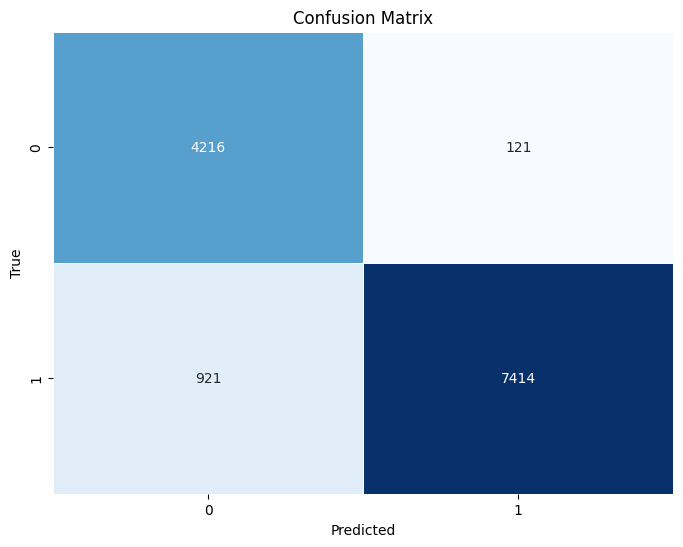

In [ ]:
conf_matrix = confusion_matrix(y_test,gb_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", linewidths=.5, cbar=False)

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.show()

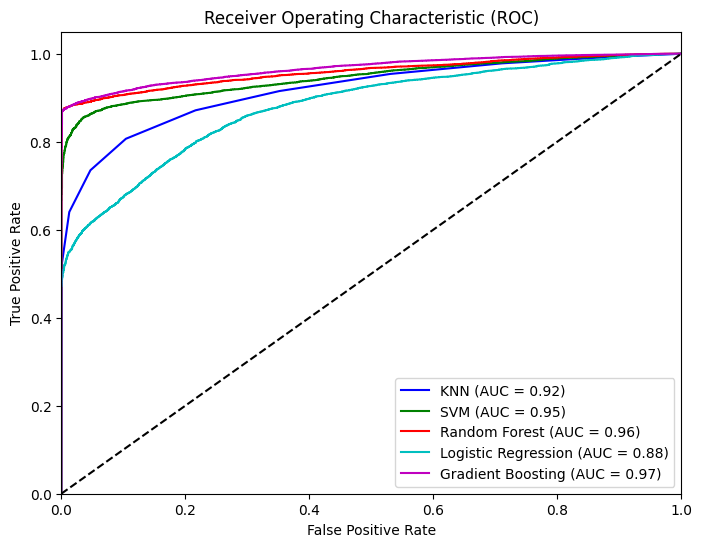

In [ ]:
# Calculate predicted probabilities for each algorithm
y_pred_proba01 = knn.predict_proba(X_test)[:,1]
y_pred_proba02 = svc_model.predict_proba(X_test)[:, 1]
y_pred_proba03 = model_rf.predict_proba(X_test)[:, 1]
y_pred_proba04 = lr_model.predict_proba(X_test)[:, 1]
y_pred_proba05 = gb_clf.predict_proba(X_test)[:, 1]



# Calculate ROC curve values for each algorithm
fpr1, tpr1, _ = roc_curve(y_test, y_pred_proba01)
fpr2, tpr2, _ = roc_curve(y_test, y_pred_proba02)
fpr3, tpr3, _ = roc_curve(y_test, y_pred_proba03)
fpr4, tpr4, _ = roc_curve(y_test, y_pred_proba04)
fpr5, tpr5, _ = roc_curve(y_test, y_pred_proba05)

# Calculate AUC (Area Under the Curve) for each algorithm
auc1 = auc(fpr1, tpr1)
auc2 = auc(fpr2, tpr2)
auc3 = auc(fpr3, tpr3)
auc4 = auc(fpr4, tpr4)
auc5 = auc(fpr5, tpr5)

# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr1, tpr1, color='b', label=f'KNN (AUC = {auc1:.2f})')
plt.plot(fpr2, tpr2, color='g', label=f'SVM (AUC = {auc2:.2f})')
plt.plot(fpr3, tpr3, color='r', label=f'Random Forest (AUC = {auc3:.2f})')
plt.plot(fpr4, tpr4, color='c', label=f'Logistic Regression (AUC = {auc4:.2f})')
plt.plot(fpr5, tpr5, color='m', label=f'Gradient Boosting (AUC = {auc5:.2f})')

plt.plot([0, 1], [0, 1], color='k', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()


AUC value of 0.97 for a Gradient Boosting classifier indicates that the classifier is performing very well in distinguishing between the positive and negative classes.

# MBA

The Market Basket Analysis is an unsupervised model which identifies and measures relationships among products.

In particular, the aim is to constructing typical market baskets by identifying the most important affinities of products from the purchases made by the customers.

In [ ]:
dataset = dataset.drop(columns="Unnamed: 0")
dataset_MBA = dataset[dataset['direction'] != -1]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Extraction of information such as lifts, supports, confidences

In [ ]:
# Compute a count for the purchases for each product
item_frequencies = dataset_MBA['product_id'].value_counts().reset_index()
item_frequencies.columns = ['product_id', 'Count']

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Order the products by that count, descending
sorted_items = item_frequencies.sort_values(by='Count', ascending=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


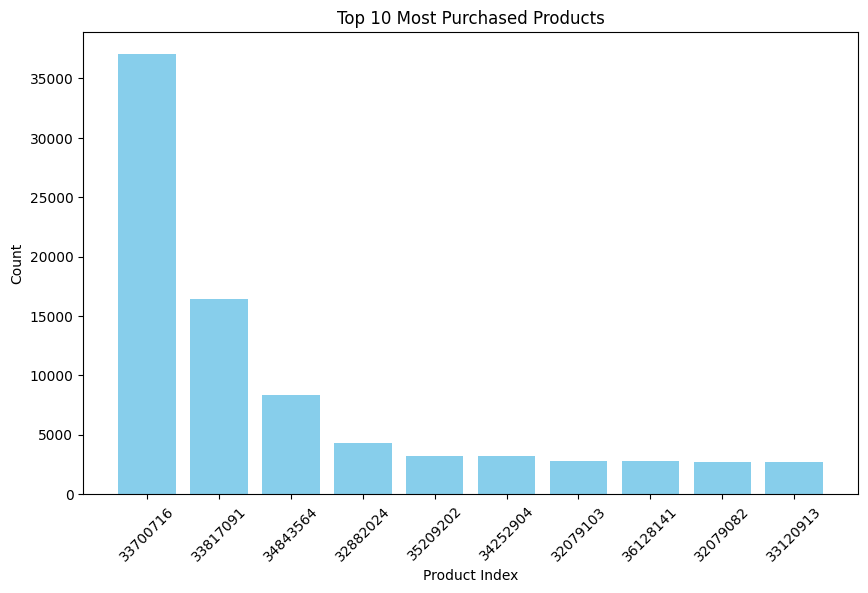

In [ ]:
# Select the top 10 purchased items and show them with a barchart

top_10_items = sorted_items.head(10)

plt.figure(figsize=(10, 6))
plt.bar(range(len(top_10_items)), top_10_items['Count'], color='skyblue')
plt.xlabel('Product Index')
plt.ylabel('Count')
plt.title('Top 10 Most Purchased Products')
plt.xticks(range(len(top_10_items)), top_10_items['product_id'], rotation=45)
plt.show()

From now on, we adjust our data and parameters with the awareness that high data usage would lead to RAM issues. Specifically, we reduce the number of rows in the analysis and enforce the method's execution only when support exceeds a certain value, all in a manner consistent with our analysis.

In [ ]:
# Select just the top N=100 purchased products
N = 100
top_N_items = sorted_items.head(N)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Create a transactions representation
transactions = dataset_MBA.groupby('order_id')['product_id'].apply(list).reset_index(name='items')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Filter the transactions to include just the most N purchased products
filtered_transactions = transactions[transactions['items'].apply(lambda x: any(item in x for item in top_N_items['product_id']))]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Create a one-hot encoding representation of the transactions
from mlxtend.preprocessing import TransactionEncoder
te = TransactionEncoder()
te_ary = te.fit(filtered_transactions['items']).transform(filtered_transactions['items'])
transaction_df = pd.DataFrame(te_ary, columns=te.columns_)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Execute fpgrowth with optimized parameters to reduce RAM usage
frequent_itemsets = fpgrowth(transaction_df, min_support=0.005, use_colnames=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
frequent_itemsets

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


support                        itemsets
0    0.008051                      (34916056)
1    0.010829                      (35874006)
2    0.016554                      (31618300)
3    0.012059                      (31618321)
4    0.011126                      (32988382)
..        ...                             ...
145  0.009166            (32842551, 32079103)
146  0.005786            (32842551, 32078935)
147  0.007686            (32079082, 32842551)
148  0.005354  (32079103, 32842551, 32078935)
149  0.006983  (32079082, 32842551, 32079103)

[150 rows x 2 columns]

In [ ]:
# Extract confidence e lift values
# assume lift threshold equal to 1, below which there is a negative correlation
lift = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)
confidence = association_rules(frequent_itemsets, metric="confidence")
rules = pd.concat([lift, confidence], ignore_index=True).drop_duplicates()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Order the rules by one of them, lift, and show the result
rules = rules.sort_values(by='lift', ascending=False)
print(rules[['antecedents', 'consequents', 'lift', 'confidence']])

    antecedents consequents       lift  confidence
117  (36298206)  (36298122)  92.852442    0.859251
116  (36298122)  (36298206)  92.852442    0.552958
101  (36298381)  (36298353)  87.550709    0.849840
100  (36298353)  (36298381)  87.550709    0.740947
15   (31047485)  (31047464)  66.215746    0.574263
..          ...         ...        ...         ...
99   (31618300)  (31618475)  24.669210    0.310331
121  (32078935)  (32842551)  22.730207    0.333723
120  (32842551)  (32078935)  22.730207    0.394107
17   (32079103)  (33700716)   1.063357    0.265737
16   (33700716)  (32079103)   1.063357    0.020097

[136 rows x 4 columns]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Lists and graphs

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


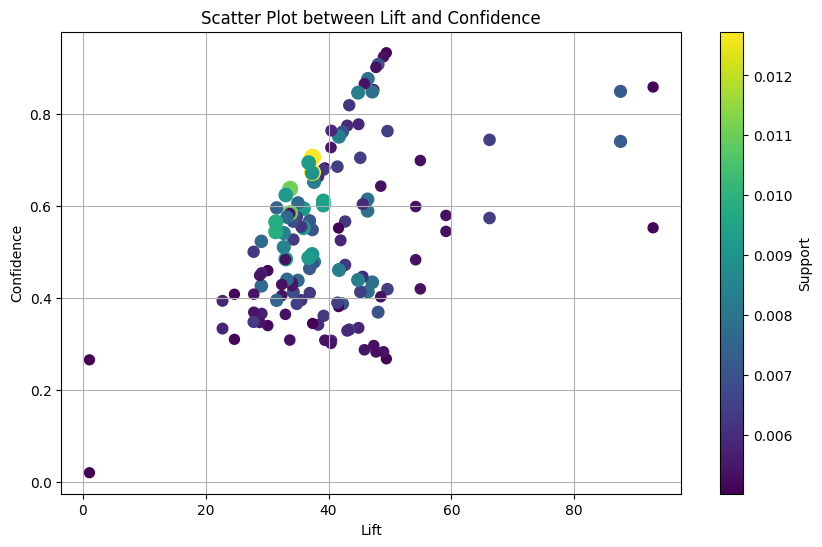

In [ ]:
# Create a scatterplot that shows correlation between lift and confidence, with a scale of dimension and color based on support

plt.figure(figsize=(10, 6))
plt.scatter(rules['lift'], rules['confidence'], s=rules['support'] * 10000, c=rules['support'], cmap='viridis')
plt.colorbar(label='Support')
plt.xlabel('Lift')
plt.ylabel('Confidence')
plt.title('Scatter Plot between Lift and Confidence')
plt.grid(True)
plt.show()

In [ ]:
# Transform all the data in antecedents and consequents in string data
rules['antecedents'] = rules['antecedents'].apply(lambda x: ', '.join(map(str, x)))
rules['consequents'] = rules['consequents'].apply(lambda x: ', '.join(map(str, x)))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


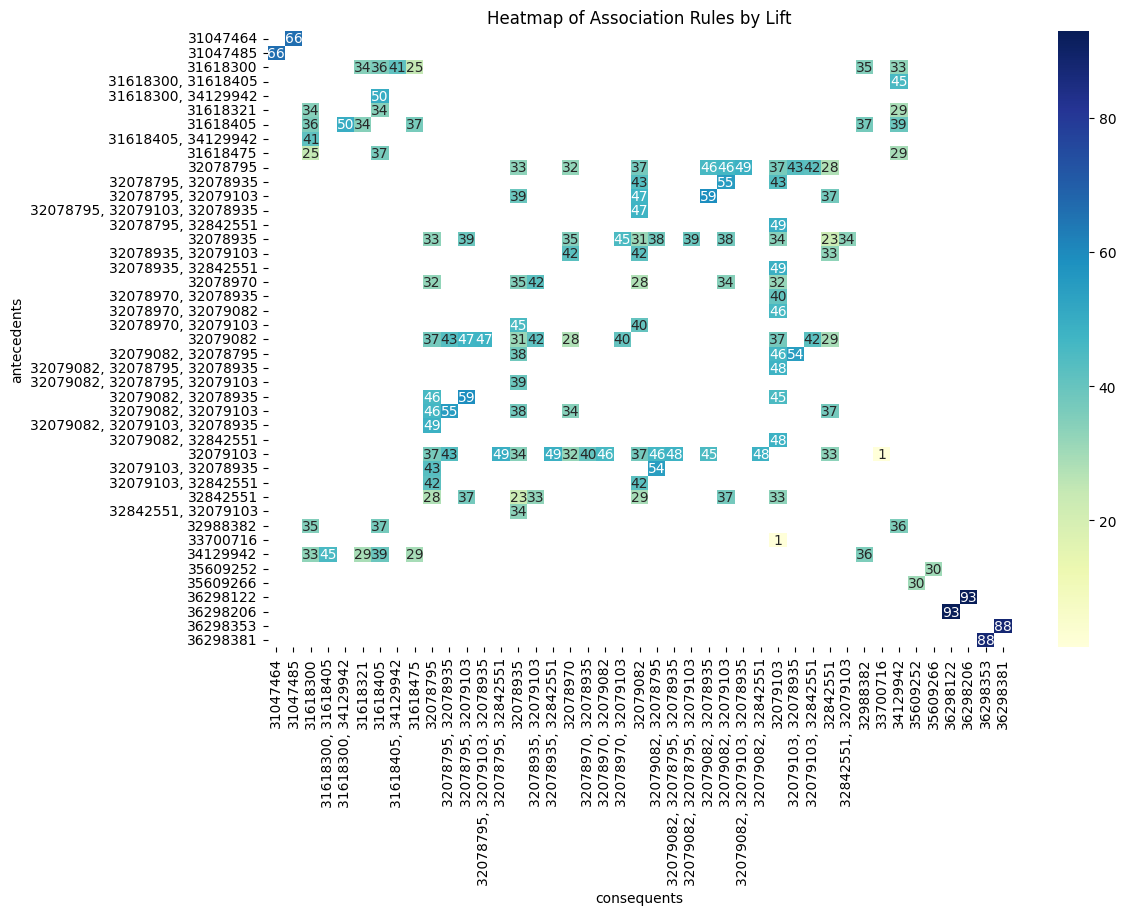

In [ ]:
# Create a data matrix to use for the heatmap
heatmap_data = pd.pivot_table(rules, values='lift', index='antecedents', columns='consequents')

# Customize graph dimension
plt.figure(figsize=(12, 8))

# Create the heatmap with seaborn
sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap="YlGnBu")

# Set a title
plt.title('Heatmap of Association Rules by Lift')

# Show the heatmap
plt.show()

In [ ]:
top_10_lift = rules.sort_values(by='lift', ascending=False).head(10)
print(top_10_lift[['antecedents', 'consequents', 'lift']])

            antecedents         consequents       lift
117            36298206            36298122  92.852442
116            36298122            36298206  92.852442
101            36298381            36298353  87.550709
100            36298353            36298381  87.550709
15             31047485            31047464  66.215746
14             31047464            31047485  66.215746
62   32078795, 32079103  32079082, 32078935  59.125048
59   32079082, 32078935  32078795, 32079103  59.125048
60   32079082, 32079103  32078795, 32078935  54.946542
61   32078795, 32078935  32079082, 32079103  54.946542


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
top_10_confidence = rules.sort_values(by='confidence', ascending=False).head(10)
print(top_10_confidence[['antecedents', 'consequents', 'confidence']])

                      antecedents consequents  confidence
68             32078795, 32842551    32079103    0.933915
126            32078935, 32842551    32079103    0.925234
130            32079082, 32842551    32079103    0.908531
54   32079082, 32078795, 32078935    32079103    0.901938
36             32079082, 32078795    32079103    0.877273
88             32078970, 32079082    32079103    0.866379
117                      36298206    36298122    0.859251
57   32078795, 32079103, 32078935    32079082    0.853290
101                      36298381    36298353    0.849840
38             32078795, 32079103    32079082    0.848974


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


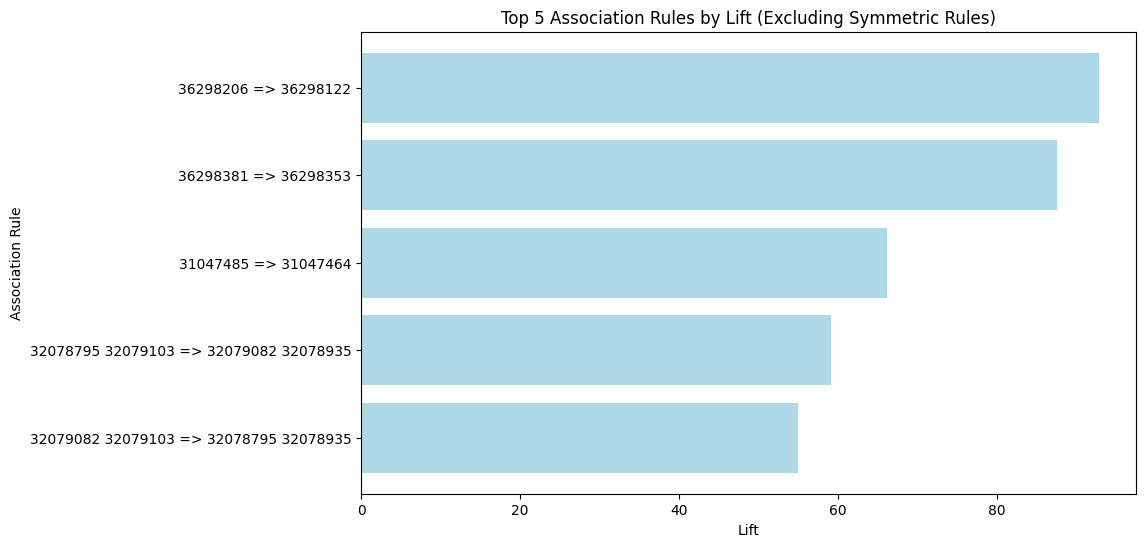

In [ ]:
# Create a horizontal bar chart for the top 10 lift rules (actually 5, as they are symmetrical)

# Remove symmetrical rules
seen_rules = set()
filtered_rules = []
rule_labels = []
for _, row in top_10_lift.iterrows():
    rule_tuple = (frozenset(row['antecedents']), frozenset(row['consequents']))
    if rule_tuple not in seen_rules and (rule_tuple[1], rule_tuple[0]) not in seen_rules:
        seen_rules.add(rule_tuple)
        filtered_rules.append(row)
        # Create a lable without commas
        antecedent_label = ''.join(map(str, row['antecedents'])).replace(',', '')
        consequent_label = ''.join(map(str, row['consequents'])).replace(',', '')
        rule_labels.append(f"{antecedent_label} => {consequent_label}")

filtered_rules_df = pd.DataFrame(filtered_rules)

# Create the graph
plt.figure(figsize=(10, 6))
plt.barh(range(len(filtered_rules_df)), filtered_rules_df['lift'], color='lightblue')
plt.yticks(range(len(filtered_rules_df)), rule_labels)
plt.xlabel('Lift')
plt.ylabel('Association Rule')
plt.title('Top 5 Association Rules by Lift (Excluding Symmetric Rules)')
plt.gca().invert_yaxis()  # Reverse the order of the rules to display the most important one at the top
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


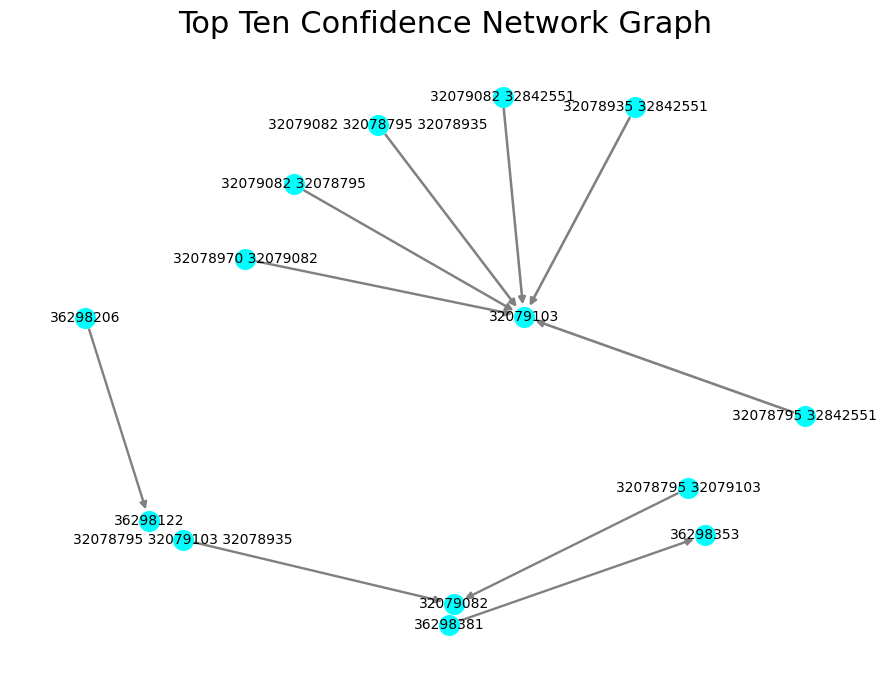

In [ ]:
# Create a direct graph
G = nx.DiGraph()

# Add nodes and edges to the graph
for index, row in top_10_confidence.iterrows():
    antecedent = ''.join(map(str, row['antecedents'])).replace(',', '')
    consequent = ''.join(map(str, row['consequents'])).replace(',', '')
    confidence = row['confidence']
    G.add_edge(antecedent, consequent, weight=confidence)

# Position the nodes using the Kamada-Kawai layout algorithm
pos = nx.kamada_kawai_layout(G)

# Customize the dimensions of the chart
plt.figure(figsize=(9, 7))

# Draw nodes and edges
nx.draw_networkx_nodes(G, pos, node_size=200, alpha=1, node_color='cyan')
nx.draw_networkx_edges(G, pos, width=[d['weight'] * 2 for (u, v, d) in G.edges(data=True)], edge_color='gray')
nx.draw_networkx_labels(G, pos, labels={node: node for node in G.nodes()}, font_size=10)

# Set the graph title and show the graph
plt.title('Top Ten Confidence Network Graph', fontsize=22)
plt.axis('off')
plt.tight_layout()
plt.show()